In [121]:
import numpy as np
import math
import sympy as sym
from scipy.integrate import ode
from scipy.io import loadmat
import scipy.io
import scipy
from scipy import stats
import pickle
import copy
import filter_functions
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 4.0)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
np.set_printoptions(precision=15)
sym.init_printing()
from IPython.display import display

#MSIS: https://github.com/DeepHorizons/Python-NRLMSISE-00
#import time
from nrlmsise_00_header import *
from nrlmsise_00 import *
#SUBROUTINE GTD7D -- d[5] is the "effective total mass density
#for drag" and is the sum of the mass densities of all species
#in this model, INCLUDING anomalous oxygen.

#define constants
r_earth_const = 6378136.3 * 1e-3 #km
omega_const = 7.2921158553e-5 #rad/s, angular velocity of earth
J_2_const = .00108262617385222
J_3_const = -.00000253241051856772
mu_earth = 3.986004415e14 * 1e-9 #km^3/s^2


#Drag:
A_const = 0.9551567 * 1e-6 #km^2; cross-sectional area of satellite
m_const = 10 #kg; mass of satellite
C_D_const = 2.0
theta_dot_const = 7.2921158553e-5 #rad/sec
print(400 + r_earth_const)

6778.1363


In [122]:

stop_time = 18000.0

num_of_objects = 5

meas_type = 3




if meas_type == 1:
    meas_file = open('Data Files/meas_range_rangeRate.pkl', 'rb')
elif meas_type == 2:
    meas_file = open('Data Files/meas_az_el.pkl', 'rb')
elif meas_type == 3:
    meas_file = open('Data Files/meas_az_el_range_MultiObj.pkl', 'rb') #_10s_all_3stat.pkl
    
    
    
#Date of Simulation Details:
#June 24th, 2017 at 6am (this is the date & time at the beginning of the simulation/orbit)
year_init = 2017
month_init = 6
day_of_month_init = 24
day_of_year_init = 175
hour_init = 6
boulder_UT_offset = 6 #Boulder time + 6 hours = UT time
hour_init_UT = hour_init + boulder_UT_offset
    
    

#Canbera Station (DSS 34)
lat_dss34 = math.radians(-35.398333)
lon_dss34 = math.radians(148.981944)
alt_dss34 = 691.75 * 1e-3 #km

r_ecef_dss34 = filter_functions.topo2ecef(lat_dss34, lon_dss34, alt_dss34, r_earth_const)
#print(r_ecef_dss34)

#Madrid Station (DSS 65) -- correct position of Madrid Station
lat_dss65 = math.radians(40.427222)
lon_dss65 = math.radians(355.749444)
alt_dss65 = 834.539 * 1e-3 #km

r_ecef_dss65 = filter_functions.topo2ecef(lat_dss65, lon_dss65, alt_dss65, r_earth_const)
#print(r_ecef_dss65)

#Goldstone Station (DSS 13) 
lat_dss13 = math.radians(35.247164)
lon_dss13 = math.radians(200.205)
alt_dss13 = 1071.14904 * 1e-3 #km

r_ecef_dss13 = filter_functions.topo2ecef(lat_dss13, lon_dss13, alt_dss13, r_earth_const)
#print(r_ecef_dss13)

#Diego Garcia, British Indian Ocean Territory 7.41173°S 72.45222°E., Space Fence (Dedicated Sensor
lat_diego = math.radians(-7.41173)
lon_diego = math.radians(72.45222)
alt_diego = 0 * 1e-3 #km, "sea level"

r_ecef_diego = filter_functions.topo2ecef(lat_diego, lon_diego, alt_diego, r_earth_const)




# read python dict containing measurements
mydict2 = pickle.load(meas_file)
meas_file.close()
measurement_array = mydict2['measurement_array']
truth_xyz = mydict2['true_state']
true_state_all_times = mydict2['true_state_all_times'] #includes truth before & after measurements occur
lat_lst_meas_array = mydict2['lat_lst_array']
print(np.shape(measurement_array))
print(np.shape(truth_xyz))


truth_xyz[:,:6] = truth_xyz[:,:6] * 1e-3 #convert to km
truth_xyz[:,-1] = truth_xyz[:,-1] * 1e9 #prep truth for filter used density magnitude/units

true_state_all_times[:,2:8] = true_state_all_times[:,2:8] * 1e-3 #convert to km
true_state_all_times[:,-1] = true_state_all_times[:,-1] * 1e9 #prep truth for filter used density magnitude/units

measurement_array[:, -1] = measurement_array[:, -1] * 1e-3 #convert to km



#calculate data time step using truth at all times
time_step = true_state_all_times[1,0] - true_state_all_times[0,0] #seconds


#specify initial index of filter simulation: anywhere from 1 ("time_step - 1") before to the first index
#initial_sim_index = int(measurement_array[0,0]/time_step - 3) #initialize for time step before first measurement 
initial_sim_index = int(measurement_array[0,0]/time_step - 1) #initialize for time step before first measurement
initial_sim_time = initial_sim_index * time_step
print(initial_sim_index, initial_sim_time)



print(measurement_array[0,0])
print('Initial measurement index: ', measurement_array[0,0]/time_step)
print('Initial simulation index: ', initial_sim_index)
#print(measurement_array[:50,:3])
print(np.linalg.norm(true_state_all_times[-1, 2:5]) - r_earth_const)

(2400, 6)
(2400, 7)
0 0.0
180.0
Initial measurement index:  1.0
Initial simulation index:  0
396.767813127


In [123]:
initial_sim_time


In [124]:
#read in files necessary for ensemble & density est. portion


# read python dict containing densities
ensemble_file = open('Data Files/ensemble_density_grids_moreRealistic.pkl', 'rb')
mydict2 = pickle.load(ensemble_file)
ensemble_file.close()

#shape: ensembles (# of combos) by lat by lon
ensembles_of_density_grid = mydict2['ensemble_of_density_grids'] 
print('Shape of Vector of State/density Ensembles:', np.shape(ensembles_of_density_grid))
(num_of_ensembles, num_of_lat, num_of_lon) = np.shape(ensembles_of_density_grid)

#convert from kg/m**3 to kg/km**3 -> 1/(1e-3)**3 = 1/(1e-9) = 1e9
ensembles_of_density_grid = ensembles_of_density_grid * 1e9

latitude_grid = mydict2['latitudes'] 
longitude_grid = mydict2['longitudes'] 
lat_res = latitude_grid[1] - latitude_grid[0] #spacing between each latitude "tick"
lon_res = longitude_grid[1] - longitude_grid[0] #spacing between each longitude "tick"



#add noise w/ standard deviation = 1e-4 (used as initialization of density covariance, as well)

print(np.sum(ensembles_of_density_grid[:, 0, 0])/num_of_ensembles)
ensemble_noise = np.random.randn(num_of_ensembles, num_of_lat, num_of_lon) * 1e-4 
ensembles_of_density_grid = ensembles_of_density_grid + ensemble_noise 
print(np.sum(ensembles_of_density_grid[:, 0, 0])/num_of_ensembles) 

print(np.mean(ensembles_of_density_grid))

Shape of Vector of State/density Ensembles: (450, 37, 73)
0.00351022831235
0.00351136479553
0.00470447248829


In [125]:

#Propogate reference trajectory and S.T.M.
def orbitpropogator_EnKF(t, X_vector, density):
    
    ensemble_member = X_vector

    #find X acceleration via the F(X) lambdified equation
    state_acc = X_dot_sol_fcn(ensemble_member[0], ensemble_member[1], ensemble_member[2], \
                                  ensemble_member[3], ensemble_member[4], ensemble_member[5], density)
        
    dx = state_acc.flatten()
    return dx


In [126]:

#EnKF specific functionality




def gen_ensemble(X_0, Bsqrt_cov, ensemble_size):
    
    X_0 = X_0.reshape(len(X_0), 1)
    
    ensemble = np.zeros((len(X_0), ensemble_size))
    
    for ii in range(ensemble_size):
        
        member = X_0 + np.dot(Bsqrt_cov, np.random.randn(len(X_0), 1))

        ensemble[:, ii] = member.reshape(len(X_0))
    
    return ensemble
    



In [127]:
#two body motion force
# **Setup force equations/acceleration/U

#Force equations with J_2
x, y, z, J_2, r_earth, mu, r, J_3 = sym.symbols('x y z J_2 r_earth mu r J_3')

'''
two_body_J2_string = 'mu/r * ( 1 - J_2*(r_earth/r)**2 * (3/2 * (z/r)**2 - 1/2) )' #potential
two_body_J2 = sym.sympify(two_body_J2_string)
two_body_J2 = two_body_J2.subs([(r, sym.sqrt(x**2+y**2+z**2))])
two_body_J2_acc_x = two_body_J2.diff(x)
two_body_J2_acc_y = two_body_J2.diff(y)
two_body_J2_acc_z = two_body_J2.diff(z)


two_body_J2_acc_x = two_body_J2_acc_x.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
two_body_J2_acc_y = two_body_J2_acc_y.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
two_body_J2_acc_z = two_body_J2_acc_z.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
#print('2 body & J2', two_body_J2_acc_x)

x_acc = two_body_J2_acc_x
y_acc = two_body_J2_acc_y
z_acc = two_body_J2_acc_z
'''

x_acc = '(-mu/r**3) * x'
y_acc = '(-mu/r**3) * y'
z_acc = '(-mu/r**3) * z'

x_acc = sym.sympify(x_acc)
y_acc = sym.sympify(y_acc)
z_acc = sym.sympify(z_acc)


x_acc = x_acc.subs([(r, sym.sqrt(x**2+y**2+z**2)), (mu, mu_earth)])
y_acc = y_acc.subs([(r, sym.sqrt(x**2+y**2+z**2)), (mu, mu_earth)])
z_acc = z_acc.subs([(r, sym.sqrt(x**2+y**2+z**2)), (mu, mu_earth)])

In [128]:
#Add drag to J_2 force equations

x_dot, y_dot, z_dot, x_double_dot, y_double_dot, z_double_dot = \
    sym.symbols('x_dot, y_dot, z_dot, x_double_dot, y_double_dot, z_double_dot')
    
C_D, A, m, density, theta_dot, val, val_dot = \
    sym.symbols('C_D A m density theta_dot val, val_dot')

    
    
drag_x = (' -(1/2) * C_D * (A/m) * density * sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +z_dot**2)   *'
                              '(x_dot+theta_dot*y) ')
drag_y = (' -(1/2) * C_D * (A/m) * density * sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +z_dot**2)   *'
                              '(y_dot-theta_dot*x) ')
drag_z = (' -(1/2) * C_D * (A/m) * density * sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +z_dot**2)   *'
                              'z_dot ')


drag_x = sym.sympify(drag_x)
drag_y = sym.sympify(drag_y)
drag_z = sym.sympify(drag_z)



drag_x = drag_x.subs([(A, A_const), (m, m_const), (C_D, C_D_const),\
                            (theta_dot, theta_dot_const)])
drag_y = drag_y.subs([(A, A_const), (m, m_const), (C_D, C_D_const),\
                            (theta_dot, theta_dot_const)])
drag_z = drag_z.subs([(A, A_const), (m, m_const), (C_D, C_D_const),\
                            (theta_dot, theta_dot_const)])


x_acc = x_acc + drag_x

y_acc = y_acc + drag_y

z_acc = z_acc + drag_z


x_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), x_acc)
y_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), y_acc)
z_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), z_acc)

In [129]:


if (meas_type == 1) or (meas_type == 3):
    
    x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot = \
        sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot')

    #define symbolic rho equation
    rho = ('sqrt((x - x_s)**2 + (y - y_s)**2 + (z - z_s)**2)')
    rho = sym.sympify(rho)
    #sub rotation equation of ecef for eci
    rho = rho.subs(x_s, x_sf*sym.cos(omega_const*t) - y_sf*sym.sin(omega_const*t))
    rho = rho.subs(y_s, x_sf*sym.sin(omega_const*t) + y_sf*sym.cos(omega_const*t))
    rho = rho.subs(z_s, z_sf)

    #define symbolic rho dot equation
    rho_dot = ('(x*x_dot + y*y_dot + z*z_dot - (x_dot*x_s+y_dot*y_s)*cos(theta) + \
               theta_dot*(x*x_s + y*y_s)*sin(theta) + (x_dot*y_s - y_dot*x_s)*sin(theta) +\
               theta_dot*(x*y_s - y*x_s)*cos(theta) - z_dot*z_s)/ rho')
    rho_dot = sym.sympify(rho_dot)
    #execute substitutions for rho_dot
    rho_dot = rho_dot.subs(x_s, x_sf) 
    rho_dot = rho_dot.subs(y_s, y_sf) 
    rho_dot = rho_dot.subs(z_s, z_sf) 
    rho_dot = rho_dot.subs('rho', rho)
    rho_dot = rho_dot.subs(theta, omega_const*t)    
    rho_dot = rho_dot.subs(theta_dot, omega_const)

    rho_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), rho)
    rho_dot_fcn = lambdify(((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t)), rho_dot)


if (meas_type == 2) or (meas_type == 3):
    
    #x_sf, etc. is the sensor pos in ecef
    #x, y, z is the satellite eci
    x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t = \
        sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t')
    x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
        x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega  = \
        sym.symbols('x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
        x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega')
        

    #define symbolic rho equation
    azimuth = ('atan2(x_L, y_L)') #step 4
    azimuth = sym.sympify(azimuth)
    
    elevation = ('asin(z_L/X_L_norm)') #step 4
    elevation = sym.sympify(elevation)
    elevation = elevation.subs(X_L_norm, sym.sqrt(x_L**2 + y_L**2 + z_L**2))
    
    #step 3
    azimuth = azimuth.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
            (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat))])
    elevation = elevation.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
            (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat)), \
            (z_L, x_range*sym.cos(lat)*sym.cos(lon) + y_range*sym.cos(lat)*sym.sin(lon) + z_range*sym.sin(lat))])
    
    #step 2
    azimuth = azimuth.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
            (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
    elevation = elevation.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
            (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
    
    #step 1
    azimuth = azimuth.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                        (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                        (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
    elevation = elevation.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                        (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                        (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
    
    
    azimuth = azimuth.subs([(theta, omega_const*t), (omega, omega_const)])
    elevation = elevation.subs([(theta, omega_const*t), (omega, omega_const)])
    
    azimuth_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), azimuth)
    elevation_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), elevation)
    



In [130]:
#State and A matrix


#define the symbolic state matrix
X = sym.Matrix([x, y, z, x_dot, y_dot, z_dot])
X_dot = sym.Matrix([x_dot, y_dot, z_dot, x_acc, y_acc, z_acc])
    

#partial of the force model (x dot) WRT the state vector
A_mat = X_dot.jacobian(X)
#print(A_mat)

A_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), A_mat)
#print(A_sol_fcn(1,2,3,4,5,6,7,8))

#print(X_dot)
X_dot_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), X_dot)

In [131]:
#define observation model (G) and H_tilde


if meas_type == 1:
    G = sym.Matrix([rho, rho_dot])
    
    
elif meas_type == 2:
    G = sym.Matrix([azimuth, elevation])
    
elif meas_type == 3:
    G = sym.Matrix([azimuth, elevation, rho])

#print(G)
G_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t), G)

#partial derivitive of observation model WRT the state vector
X_full = X = sym.Matrix([x, y, z, x_dot, y_dot, z_dot, density])
H_tilde = G.jacobian(X_full)
#print(H_tilde[:,-1])
H_tilde_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t), H_tilde)

In [132]:



def calc_P_TU(X_mean, ensemble):
    
    dimension = len(X_mean)
    
    P_bar_sum = np.zeros((dimension, dimension))
    
    for ii in range(num_of_ensembles):

        X = ensemble[:, ii].reshape(dimension, 1)
        diff_X = X - X_mean
        P_bar_sum = P_bar_sum + np.dot(diff_X, diff_X.T)

    P_bar = P_bar_sum/(num_of_ensembles-1)

    return P_bar



In [133]:
#define reference state at epoch, covariance at epoch, and R (using measurement noise)

pos_perturbation = 100 * 1e-3 #km
vel_perturbation = .1 * 1e-3 #km/s

density_dimension = num_of_lat * num_of_lon
prob_dimension = 6 * num_of_objects
fullState_dimension = prob_dimension + density_dimension

single_obj_fullState_dim = 6 + density_dimension



X_ref = np.zeros((num_of_objects, 6))
P_bar_0 = np.zeros((num_of_objects, 7, 7))
X_RV_ensemble = np.zeros(())



for ii in range(num_of_objects):

    
    indices = np.where(true_state_all_times[:, 1] == (ii+1))[0] #find indices of truth that pertain to this object
    initial_RV = true_state_all_times[np.r_[indices],:][initial_sim_index] #select specificed initial index for sim
    print(initial_RV[0])

    X_ref[ii,:] = np.array([initial_RV[2] + pos_perturbation, initial_RV[3] + pos_perturbation, initial_RV[4] \
                + pos_perturbation, initial_RV[5] + vel_perturbation, initial_RV[6] + vel_perturbation, \
                initial_RV[7] + vel_perturbation])
    
    
X_ref = X_ref.reshape(prob_dimension)


P_sigma_pos = 100 * 1e-3 #km
P_sigma_vel = .1 * 1e-3 #km/s
P_bar_0_singleObj = [P_sigma_pos**2, P_sigma_pos**2, P_sigma_pos**2, \
                   P_sigma_vel**2, P_sigma_vel**2, P_sigma_vel**2]

P_bar_0_multiObj = np.tile(P_bar_0_singleObj, num_of_objects)
P_bar_0_multiObj = np.append(P_bar_0_multiObj, (1e-4)**2) #add density at the end
P_bar_0 = np.diag(P_bar_0_multiObj)




(L, V) = np.linalg.eig(P_bar_0[:prob_dimension, :prob_dimension]) #eigenvalues, eigenvectors
Bsqrt_cov = V * np.sqrt(L)
X_RV_ensemble = gen_ensemble(X_ref, Bsqrt_cov, num_of_ensembles)
print(np.shape(X_RV_ensemble))


  


#for process noise
snc_sigma = 1e-5

       
                  
#Define Measurement Noise
if meas_type == 1:
    sigma_rho = .1 * 1e-3 #km
    sigma_rho_dot = .01 * 1e-3 #km/s
    W = np.array([[1/sigma_rho**2, 0], [0, 1/sigma_rho_dot**2]])
    R = np.linalg.inv(W)
    
elif meas_type == 2:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * 5  #5 arcsec noise (suggested by Moriba for a telescope)
    sigma_az = noise_rad
    sigma_el = noise_rad
    W = np.array([[1/sigma_az**2, 0], [0, 1/sigma_el**2]])
    R = np.linalg.inv(W)
    
elif meas_type == 3:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * .15  #5 arcsec noise (suggested by Moriba for a telescope)
    sigma_az = noise_rad #noise_rad
    sigma_el = noise_rad #noise_rad
    sigma_rho = .1 * 1e-3 #km
    W = np.array([[1/sigma_az**2, 0, 0], [0, 1/sigma_el**2, 0], [0, 0, 1/sigma_rho**2]])
    R = np.linalg.inv(W)
    
    meas_indices = np.array([0, 1, 2])


#reduced rank variable for number of eigvals
q = 39

    
print(X_ref)

0.0
0.0
0.0
0.0
0.0
(30, 450)
[ -6.521102118094243e+03  -1.651842712689856e+03   8.296419882873489e+02
   1.109149113516644e+00  -6.413896859461329e+00  -4.054211886021712e+00
   2.633943697511361e+01   6.651716281183366e+03   1.303343661492849e+03
  -6.851067985598363e+00  -6.362411205186069e-01   3.385858073158500e+00
   2.225972527196900e+03  -6.166504270525891e+03  -1.720834329014218e+03
   7.237565975864366e+00   2.506302666215688e+00   3.806587504811489e-01
  -3.151282012133742e+03   4.927885467215964e+03   3.424841377691565e+03
  -6.438283755400389e+00  -4.165145655815669e+00   6.890235035114856e-02
   4.481323622711126e+03  -2.176776300996572e+03  -4.595873902753687e+03
   4.309288023625062e+00   6.217699361693121e+00   1.256741266642296e+00]


In [134]:
true_state_all_times[initial_sim_index,:]

array([  0.000000000000000e+00,   1.000000000000000e+00,
        -6.521202118094243e+03,  -1.651942712689856e+03,
         8.295419882873489e+02,   1.109049113516644e+00,
        -6.413996859461329e+00,  -4.054311886021711e+00,
         5.411672026933581e-03])

In [135]:
#prnt(h)
"""

index_firstMeas = int(27910/10)

indices = np.where(true_state_all_times[:,1] == 5)[0]  
true_state_thisObj = true_state_all_times[np.r_[indices,:]][index_firstMeas]
true_dens = true_state_thisObj[-1]
print(true_dens)
print(truth_xyz[0,-1])


obj_index_begin = 4*6
obj_index_end = (4+1)*6
(lat_grid_ticks, lst_grid_ticks) = filter_functions.calc_lat_lst_indices(27910, \
                        truth_xyz[0,:3], day_of_month_init, hour_init_UT, month_init, \
                                       year_init, omega_const, r_earth_const, lat_res, lon_res)

print(lat_grid_ticks, lst_grid_ticks)
lat_grid_ticks = 24
lst_grid_ticks = 38
print('est:', np.degrees(latitude_grid[lat_grid_ticks]), np.degrees(longitude_grid[lst_grid_ticks]))
print('true:', np.degrees(lat_lst_meas_array[0, :]))



est_dens = np.mean(ensembles_of_density_grid.reshape(num_of_ensembles, num_of_lat, num_of_lon)[:, 24, 38])
print(np.mean(est_dens))

est_dens = ensembles_of_density_grid.reshape(num_of_ensembles, num_of_lat, num_of_lon)\
                                                                      [:, lat_grid_ticks+1, lst_grid_ticks]
print(np.mean(est_dens))
est_dens = ensembles_of_density_grid.reshape(num_of_ensembles, num_of_lat, num_of_lon)\
                                                                      [:, lat_grid_ticks, lst_grid_ticks+1]
print(np.mean(est_dens))
"""

"\n\nindex_firstMeas = int(27910/10)\n\nindices = np.where(true_state_all_times[:,1] == 5)[0]  \ntrue_state_thisObj = true_state_all_times[np.r_[indices,:]][index_firstMeas]\ntrue_dens = true_state_thisObj[-1]\nprint(true_dens)\nprint(truth_xyz[0,-1])\n\n\nobj_index_begin = 4*6\nobj_index_end = (4+1)*6\n(lat_grid_ticks, lst_grid_ticks) = filter_functions.calc_lat_lst_indices(27910,                         truth_xyz[0,:3], day_of_month_init, hour_init_UT, month_init,                                        year_init, omega_const, r_earth_const, lat_res, lon_res)\n\nprint(lat_grid_ticks, lst_grid_ticks)\nlat_grid_ticks = 24\nlst_grid_ticks = 38\nprint('est:', np.degrees(latitude_grid[lat_grid_ticks]), np.degrees(longitude_grid[lst_grid_ticks]))\nprint('true:', np.degrees(lat_lst_meas_array[0, :]))\n\n\n\nest_dens = np.mean(ensembles_of_density_grid.reshape(num_of_ensembles, num_of_lat, num_of_lon)[:, 24, 38])\nprint(np.mean(est_dens))\n\nest_dens = ensembles_of_density_grid.reshape(num_of

In [136]:
"""
est_dens = ensembles_of_density_grid.reshape(num_of_ensembles, num_of_lat, num_of_lon)\
                                                                      [:, lat_grid_ticks, lst_grid_ticks]
print(np.mean(est_dens))




dens_ens = ensembles_of_density_grid.reshape(num_of_ensembles, density_dimension).T
X_ensemble = np.zeros((fullState_dimension, num_of_ensembles))
X_ensemble[:prob_dimension, :] = X_RV_ensemble
X_ensemble[prob_dimension:, :] = dens_ens



est_dens = X_ensemble[prob_dimension:, :].T.reshape(num_of_ensembles, num_of_lat, num_of_lon)\
                                                                      [:, lat_grid_ticks, lst_grid_ticks]
print(np.mean(est_dens))


X_mean = np.sum(X_ensemble, axis=1).reshape(fullState_dimension,1)/num_of_ensembles
print(X_mean[prob_dimension:].T.reshape(num_of_lat, num_of_lon)[lat_grid_ticks, lst_grid_ticks])
"""

'\nest_dens = ensembles_of_density_grid.reshape(num_of_ensembles, num_of_lat, num_of_lon)                                                                      [:, lat_grid_ticks, lst_grid_ticks]\nprint(np.mean(est_dens))\n\n\n\n\ndens_ens = ensembles_of_density_grid.reshape(num_of_ensembles, density_dimension).T\nX_ensemble = np.zeros((fullState_dimension, num_of_ensembles))\nX_ensemble[:prob_dimension, :] = X_RV_ensemble\nX_ensemble[prob_dimension:, :] = dens_ens\n\n\n\nest_dens = X_ensemble[prob_dimension:, :].T.reshape(num_of_ensembles, num_of_lat, num_of_lon)                                                                      [:, lat_grid_ticks, lst_grid_ticks]\nprint(np.mean(est_dens))\n\n\nX_mean = np.sum(X_ensemble, axis=1).reshape(fullState_dimension,1)/num_of_ensembles\nprint(X_mean[prob_dimension:].T.reshape(num_of_lat, num_of_lon)[lat_grid_ticks, lst_grid_ticks])\n'

In [137]:
day_of_year_nom = 175 #June 24th
f107_nom = 180
ap_nom = 10


lon = 0 #dependent only on lst


Output = nrlmsise_output()
Input = nrlmsise_input()
flags = nrlmsise_flags()
aph = ap_array()

for i in range(7):
    aph.a[i]=100
flags.switches[0] = 1
for i in range(1, 24):
    flags.switches[i]=1

Input.doy = day_of_year_init
Input.year = 0 #/* without effect */
Input.sec = 0
Input.alt = 398.722 #400 #convert to km
Input.g_lat = 29.498 #30#math.degrees(lat_lst_meas_array[0, 0])
Input.g_long = 0
Input.lst = 12.820 #(190/360) * 24 #lat_lst_meas_array[0, 1]/(2*math.pi) * 24
Input.f107A = f107_nom #/* 81 day average of F10.7 flux (centered on doy) */
Input.f107 = f107_nom #/* daily F10.7 flux for previous day */
Input.ap = ap_nom 

gtd7d(Input, flags, Output)

density = Output.d[5] #total mass density (grams/m^3, m^3 b/c switches[0] = 1)
print(density*1e9)
print(day_of_year_init)

0.00796263841797505
175


In [138]:
lat_lst_meas_array[0, 1]/(2*math.pi) * 24


In [139]:
#KALMAN

def execute_enkf(obs_data, X_RV_ensemble, P, R, X_density_ensemble,\
                         prob_dimension, density_dimension, initial_sim_time, stop_index):
    
    #initializations
    Q_ECI = np.zeros((6,6)) #*******
    
    num_of_meas = np.shape(R)[0]
    X_7elem_mean_updated = np.sum(X_RV_ensemble, axis=1)/num_of_ensembles

    pre_fit_list = np.zeros((stop_index, num_of_meas))
    prefit_bounds_list = np.zeros((stop_index, num_of_meas))
    post_fit_list = np.zeros((stop_index, num_of_meas))
    
    xpos_info_array = np.zeros((stop_index))

    P_list = np.zeros((stop_index, prob_dimension+1, prob_dimension+1))
    #P_full_list = np.zeros((21, fullState_dimension, fullState_dimension))
    X_7elem_mean_updated_list = np.zeros((stop_index, prob_dimension+1))
    X_7elem_mean_TU_list = np.zeros(((TU_array_length), prob_dimension+num_of_objects))

    
    density_MSIS_array = np.zeros(stop_index)
    #est_density_grid_array = np.zeros((stop_index, num_of_lat, num_of_lon))

    
    X_distribution = np.zeros((prob_dimension, num_of_ensembles, stop_index))
    density_distribution = np.zeros((num_of_ensembles, stop_index))
    lat_lst_array = np.zeros((2, stop_index))
    X_ensemble = np.zeros((fullState_dimension, num_of_ensembles))

    
    #for Reduced Rank
    dens_ens = X_density_ensemble.reshape(num_of_ensembles, density_dimension).T
    X_ensemble = np.zeros((fullState_dimension, num_of_ensembles))
    X_ensemble[:prob_dimension, :] = X_RV_ensemble
    X_ensemble[prob_dimension:, :] = dens_ens

    #mean of X state & density state over ensemble
    X_mean = np.sum(X_ensemble, axis=1).reshape(fullState_dimension,1)/num_of_ensembles
    P = calc_P_TU(X_mean, X_ensemble)
    
    eigvals, eigvecs = np.linalg.eig(P)
    eigvec_truncated = eigvecs[:, :q]
    eigvals_truncated = eigvals[:q]
    L = np.dot(eigvec_truncated, np.diag(np.sqrt(eigvals_truncated)))
    L = np.real(L)
    
    counter = 0
    
    
    t_init = initial_sim_time
    time = t_init + time_step
    obsnum = 0
    
    
    #print(np.mean(X_ensemble[prob_dimension:, :].T.reshape(num_of_ensembles, num_of_lat, num_of_lon)[:, 24, 38]))
    
    
    indices = np.where(true_state_all_times[:,1] == 1)[0]  
    true_state_thisObj = true_state_all_times[np.r_[indices,:]][initial_sim_index+counter]
    true_dens = true_state_thisObj[-1]
    #print('true:', true_dens)
    
    

    while time < obs_data[stop_index,0]:
    #for obsnum in range(len(obs_data[:stop_index])):
    
        print(time)
        
   
         
        #reduced rank
        epsilon = .95 #number close to 1
        X_mean_wSigma_array = np.tile(X_mean, q) + epsilon*L
        
        
        if counter == 0:
            obj_index_begin = 4*6
            obj_index_end = (4+1)*6
            (lat_grid_ticks, lst_grid_ticks) = filter_functions.calc_lat_lst_indices(t_init, \
                        X_mean[obj_index_begin:(obj_index_begin+3),0], day_of_month_init, hour_init_UT, month_init, \
                                       year_init, omega_const, r_earth_const, lat_res, lon_res)
    

        est_dens = np.mean(X_ensemble[prob_dimension:,:].T.reshape(num_of_ensembles, num_of_lat, num_of_lon)\
                                                                      [:, lat_grid_ticks, lst_grid_ticks])
            
        #print('est:', np.degrees(latitude_grid[lat_grid_ticks]), np.degrees(longitude_grid[lst_grid_ticks]))
        #print(lat_grid_ticks, lst_grid_ticks)
        #print(true_dens - est_dens)
        #print('est:', est_dens)
        #print('true:', true_dens)
        
        
        
        
        
        indices = np.where(true_state_all_times[:,1] == 1)[0]  
        true_state_thisObj = true_state_all_times[np.r_[indices,:]][initial_sim_index+counter]
        
        obj_index_begin = (0)*6
        obj_index_end = (1+1)*6
        #print(X_mean[obj_index_begin:obj_index_end].T - true_state_thisObj[2:8])
        
        
        
        
        result = X_RV_ensemble
        
        #if (obsnum != 0): still need to propagate if obsnum == 0, b/c initializations occur at t=0 not 1st obs
        for obj in range(num_of_objects):
            
            obj_index_begin = obj*6
            obj_index_end = (obj+1)*6
            
            #determine density to be used in propagation
            (lat_grid_ticks, lst_grid_ticks) = filter_functions.calc_lat_lst_indices(t_init, \
                            X_mean[obj_index_begin:(obj_index_begin+3),0], day_of_month_init, hour_init_UT, month_init, \
                                   year_init, omega_const, r_earth_const, lat_res, lon_res)
            densities = X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks]
            #print(np.mean(densities))


            for ii in range(num_of_ensembles):
                #set the initial values for the propogator:
                y0 = X_RV_ensemble[obj_index_begin:obj_index_end, ii]
                density = densities[ii]
            
                integrator = ode(orbitpropogator_EnKF)
                integrator.set_integrator('dopri5', nsteps=1e6, rtol=1e-12, atol=1e-12)
                integrator.set_f_params(density)
                integrator.set_initial_value(y0, t_init)
                integrator.integrate(time)
                result[obj_index_begin:obj_index_end, ii] = integrator.y
        
        X_RV_ensemble = result.reshape(prob_dimension, num_of_ensembles)
        
        
        #create array that holds X state ensemble & density state ensemble combined
        density_state = X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks]
        X_ensemble[:prob_dimension, :] = X_RV_ensemble
        X_ensemble[prob_dimension:, :] = X_density_ensemble.reshape(num_of_ensembles, density_dimension).T 
        
        
        #print(np.mean(X_ensemble[prob_dimension:, :].T.reshape(num_of_ensembles, num_of_lat, num_of_lon)[:, 24, 38]))
        #print(np.mean(X_ensemble[prob_dimension:,:].T.reshape(num_of_ensembles, num_of_lat, num_of_lon)\
                                                                      #[:, lat_grid_ticks, lst_grid_ticks]))
        
        
        
        
        #reduced rank
        result = X_mean_wSigma_array[:prob_dimension,:]
        result_mean = X_mean[:prob_dimension]
        
        #if (obsnum != 0): still need to propagate if obsnum == 0, b/c initializations occur at t=0 not 1st obs
        for obj in range(num_of_objects):
            
            obj_index_begin = obj*6
            obj_index_end = (obj+1)*6
            
            #determine density to be used in propagation
            (lat_grid_ticks, lst_grid_ticks) = filter_functions.calc_lat_lst_indices(t_init, \
                            X_mean[obj_index_begin:(obj_index_begin+3),0], day_of_month_init, hour_init_UT, month_init, \
                                   year_init, omega_const, r_earth_const, lat_res, lon_res)
            densities = X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks]

            
            for ii in range(q):
                y0 = X_mean_wSigma_array[obj_index_begin:obj_index_end, ii]
                density = densities[ii]
            
                integrator = ode(orbitpropogator_EnKF)
                integrator.set_integrator('dopri5', nsteps=1e6, rtol=1e-12, atol=1e-12)
                integrator.set_f_params(density)
                integrator.set_initial_value(y0, t_init)
                integrator.integrate(time)
                result[obj_index_begin:obj_index_end, ii] = integrator.y
                
            
            y0 = X_mean[obj_index_begin:obj_index_end]
            density = np.mean(densities[ii])

            integrator = ode(orbitpropogator_EnKF)
            integrator.set_integrator('dopri5', nsteps=1e6, rtol=1e-12, atol=1e-12)
            integrator.set_f_params(density)
            integrator.set_initial_value(y0, t_init)
            integrator.integrate(time)
            result_mean[obj_index_begin:obj_index_end] = integrator.y    
            
        
        X_mean_wSigma_array_TU = np.zeros((fullState_dimension, q))
        X_mean_wSigma_array_TU[:prob_dimension,:] = result.reshape(prob_dimension, q)
        X_mean_wSigma_array_TU[prob_dimension:,:] = X_mean_wSigma_array[prob_dimension:,:]
        
        X_mean_TU = np.zeros((fullState_dimension, 1))
        X_mean_TU[:prob_dimension, 0] = result_mean.reshape(prob_dimension)
        X_mean_TU[prob_dimension:, 0] = X_mean[prob_dimension:].reshape(density_dimension)

        L = (1/epsilon) * (X_mean_wSigma_array_TU - np.tile(X_mean_TU, q))
        
        
        #Use SNC P_bar if delta t is less than 100 seconds---------------------------
        if (obs_data[obsnum, 0] != obs_data[obsnum-1, 0]) and (obsnum != 0):
            delta_t = time_step
            if snc_flag:
                #build SNC STM
                idenity_6_3 = np.array([(delta_t/2)*np.eye(3), np.eye(3)]).reshape(6, 3)
                snc_stm = delta_t*idenity_6_3
                #Covariance with SNC: Q Matrix
                Q = np.identity(3)*(snc_sigma)**2

                #Q_entire = np.zeros((fullState_dimension, fullState_dimension))
                #Q_entire[:prob_dimension, :prob_dimension] = np.dot(snc_stm, np.dot(Q, snc_stm.T))
                #instead:
                FQ = np.zeros((fullState_dimension, prob_dimension))
                FQ[:prob_dimension, :prob_dimension] = np.dot(snc_stm, np.dot(Q, snc_stm.T))
                
                #build density portion of Q
                #Q_entire[prob_dimension:, prob_dimension:] = np.eye(density_dimension, density_dimension) * 1e-9
                
                #Eq. 24:
                L_tilde = np.zeros((fullState_dimension, q+prob_dimension))
                L_tilde[:, :q] = L
                L_tilde[:, q:] = FQ #Q_entire
                
                #Eq. 25:
                eigvals, X = np.linalg.eig(np.dot(L_tilde.T, L_tilde)) 
                L = np.dot(L_tilde, X)[:, :q]
                

        
        #mean of X state & density state over ensemble, reduced rank, *re-definition of X_mean on purpose*
        X_mean = np.sum(X_ensemble, axis=1).reshape(fullState_dimension,1)/num_of_ensembles #Eq. 16
        E = X_ensemble - np.tile(X_mean, num_of_ensembles) #Eq. 17
        
        
        
        
        #save propagation results; will be over-written w/ MU values if measurement at this time
        X_7elem_mean_TU = np.zeros((prob_dimension+num_of_objects))
        X_7elem_mean_TU[:prob_dimension] = \
                            np.sum(X_ensemble[:prob_dimension,:], axis=1)/num_of_ensembles
            
        #for TU density loop through objects, so calc indices for each object before grabbing its mean density
        for jj in range(num_of_objects): 
            ID = jj+1
            obj_index_begin = (ID-1)*6
            (lat_grid_ticks, lst_grid_ticks) = filter_functions.calc_lat_lst_indices(time, \
                        X_mean[obj_index_begin:(obj_index_begin+3),0], day_of_month_init, hour_init_UT, month_init, \
                                       year_init, omega_const, r_earth_const, lat_res, lon_res)
            X_7elem_mean_TU[prob_dimension+jj] = \
                                np.sum(X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks])/num_of_ensembles
            X_7elem_mean_TU_list[counter, :] = X_7elem_mean_TU

       
        
        
        indices = np.where(true_state_all_times[:,1] == 1)[0]  
        true_state_thisObj = true_state_all_times[np.r_[indices,:]][initial_sim_index+counter]
        true_dens = true_state_thisObj[-1]
        est_dens = np.mean(X_ensemble[prob_dimension:,:].T.reshape(num_of_ensembles, num_of_lat, num_of_lon)\
                                                                      [:, lat_grid_ticks, lst_grid_ticks])
        
        

        
        
        
        #-------------------Measurement Update--------------------------------------------------------
        
        
        indices_4_timeStep = np.where(obs_data[:,0] == time)[0]
        for jj in range(len(indices_4_timeStep)):

            obsnum = indices_4_timeStep[jj]
            
            

            
            #based on object ID, calculate indices in the state for this update
            ID = int(obs_data[obsnum, 2])
            obj_index_begin = (ID-1)*6
            obj_index_end = ID*6
            print('obs#', obsnum, 'obj', ID)
            
            
            
            #print('             ******')
            #print('est:', np.degrees(latitude_grid[lat_grid_ticks]), np.degrees(longitude_grid[lst_grid_ticks]))
            #print('true:', np.degrees(lat_lst_meas_array[obsnum, :]))
            #print('diff:', true_dens - est_dens)
            #print('est:', est_dens)
            #print('true:', true_dens)
            
            
            
            
            
            
            #determine density to be used in propagation
            (lat_grid_ticks, lst_grid_ticks) = filter_functions.calc_lat_lst_indices(t_init, \
                            X_mean[obj_index_begin:(obj_index_begin+3),0], day_of_month_init, hour_init_UT, month_init, \
                                   year_init, omega_const, r_earth_const, lat_res, lon_res)
            

        
            #determine station coordinates for observation eq.
            if int(obs_data[obsnum, 1]) == 1:
                #print('1')
                station_index = 0
                X_s = r_ecef_dss34
            if int(obs_data[obsnum, 1]) == 2:
                #print('2')
                station_index = 1
                X_s = r_ecef_dss65
            if int(obs_data[obsnum, 1]) == 3:
                #print('amos')
                station_index = 3
                X_s = r_ecef_diego





            #assuming Eq. 31 is supposed to be ensemble - x_mean, not just ensemble
            #below is the alternative to Eq. 32 (determined by Penny & I)
            EtransposeE = np.dot(E.T, E)
            eigvals, X = np.linalg.eig(EtransposeE)
            E_perp = np.dot(E, X)[:,q:] #Eq. 32 alternative

            E_doublePrime = np.dot(E, X)[:,:q] #Eq. 35 alternative

            lambdaa = .1 #.2
            P = lambdaa * np.dot(L, L.T) + \
                    ((1-lambdaa)/(num_of_ensembles-1)) * np.dot(E_doublePrime, E_doublePrime.T) \
                                    + (1/(num_of_ensembles-1)) * np.dot(E_perp, E_perp.T) #Eq. 37


            
            H = np.zeros((num_of_meas, fullState_dimension))
            indices = np.r_[obj_index_begin:obj_index_end, prob_dimension:prob_dimension+1]
            H[:num_of_meas, indices] = H_tilde_sol_fcn(*X_mean[obj_index_begin:obj_index_end,0], *X_s, time)

            part1 = np.dot(P, H.T)
            part2 = np.dot(H, np.dot(P, H.T))
            K = np.dot(part1, np.linalg.inv(part2 + R)) #Eq. 34
            
            #Tracer() ()
            #print(P[0,prob_dimension:].reshape(num_of_lat, num_of_lon)[lat_grid_ticks, lst_grid_ticks])
            #print(part2)
            
            gain = np.zeros((1,3))
            gain[0,0] = K[prob_dimension:,0].reshape(num_of_lat, num_of_lon)[lat_grid_ticks, lst_grid_ticks]
            gain[0,1] = K[prob_dimension:,1].reshape(num_of_lat, num_of_lon)[lat_grid_ticks, lst_grid_ticks]
            gain[0,2] = K[prob_dimension:,2].reshape(num_of_lat, num_of_lon)[lat_grid_ticks, lst_grid_ticks]
            #print('gain:', gain)

            #computations needed for Eq. 20
            Hx_array = np.zeros((num_of_meas, num_of_ensembles))
            Hx = np.zeros(3)
            for ii in range(num_of_ensembles):

                X = X_RV_ensemble[obj_index_begin:obj_index_end, ii]
                Hx = G_sol_fcn(*X, *X_s, time)

                if (meas_type != 1) and (Hx[0] < 0): #if az less than 0, add 2*pi
                    Hx[0] = Hx[0] + 2*math.pi

                Hx_array[:, ii] = Hx.reshape(num_of_meas)

            
            #get actual observation
            y_observed = obs_data[obsnum, 3:(3+num_of_meas)].reshape(num_of_meas,1)

            #Eq. 20:
            X_ensemble_updated = np.zeros((fullState_dimension, num_of_ensembles))
            correction_array = np.zeros((num_of_ensembles, fullState_dimension))
            for ii in range(num_of_ensembles):

                e = np.sqrt(np.diag(R)).reshape(num_of_meas, 1) * np.random.randn(num_of_meas, 1)
                
                correction = \
                np.dot(K, (y_observed + e - Hx_array[:, ii].reshape(num_of_meas, 1))).reshape(fullState_dimension)
                correction_array[ii] = correction
                
                correction[:obj_index_begin] = np.zeros((obj_index_begin))
                correction[obj_index_end:prob_dimension] = np.zeros((prob_dimension - obj_index_end))
                

                X_member_updated = X_ensemble[:, ii].reshape(fullState_dimension, 1) + \
                                                                        correction.reshape(fullState_dimension, 1)

                X_ensemble_updated[:, ii] = X_member_updated.reshape(fullState_dimension)



            #update overall density grid ensemble with this lat/lon's updated density values 
            X_density_ensemble = copy.deepcopy(X_ensemble_updated[prob_dimension:,:].T.reshape(num_of_ensembles, \
                                                                                            num_of_lat, num_of_lon)) 
            X_ensemble = copy.deepcopy(X_ensemble_updated)
            #est_density_grid_array[obsnum] = np.mean(X_density_ensemble, axis=0)
            
            
            
            correction_mean = np.sum(correction_array, axis=0)/num_of_ensembles
            diff = y_observed - Hx_array[:, ii].reshape(num_of_meas, 1)
            #print('diff:', diff)
            #print('diff*gain:', np.dot(gain, diff))
            #print('cor:', correction_mean[prob_dimension:].reshape(num_of_lat, num_of_lon)\
                              #[lat_grid_ticks, lst_grid_ticks])
            
            


            #SRF Update equations for updating L for next obs time
            #Eq. 28, using X_mean b/c paper shows mean being propagated then used, not
            #ensemble being propagated and then the mean calculated and used
            Hx = G_sol_fcn(*X_mean[obj_index_begin:obj_index_end,0], *X_s, time)
            X_mean_MU = X_mean + np.dot(K, y - Hx) #not used? Eq. 28


            #Eq. 29:
            H = np.zeros((num_of_meas, fullState_dimension))
            indices = np.r_[obj_index_begin:obj_index_end, prob_dimension:prob_dimension+1]
            H[:num_of_meas, indices] = H_tilde_sol_fcn(*X_mean[obj_index_begin:obj_index_end,0], *X_s, time)

            L_tilde = np.zeros((fullState_dimension, q+num_of_meas))
            part1 = np.eye(fullState_dimension, fullState_dimension) - np.dot(K, H)
            L_tilde[:, :q] = np.dot(part1, L)
            L_tilde[:, q:] = np.dot(K, np.sqrt(R)) #Eq. 29

            #Eq. 30
            eigvals, X = np.linalg.eig(np.dot(L_tilde.T, L_tilde))
            L = np.dot(L_tilde, X)[:, :q]




            #save values
            X_7elem_mean_updated = np.zeros((prob_dimension+1))
            X_7elem_mean_updated[:prob_dimension] = \
                                np.sum(X_ensemble_updated[:prob_dimension,:], axis=1)/num_of_ensembles
            X_7elem_mean_updated[prob_dimension:] = np.sum(X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks])\
                                                                                                /num_of_ensembles
            X_7elem_mean_updated_list[obsnum, :] = X_7elem_mean_updated

            #save values for analysis of distributions and such
            density_distribution[:, obsnum] = X_density_ensemble[:, lat_grid_ticks, lst_grid_ticks] 
            X_distribution[:, :, obsnum] = X_ensemble_updated[:prob_dimension, :]
            lat_lst_array[:, obsnum] = \
                np.array([latitude_grid[lat_grid_ticks], longitude_grid[lst_grid_ticks]]).reshape(2)




            P_list[obsnum, :prob_dimension, :prob_dimension] = P[:prob_dimension, :prob_dimension]
            P_list[obsnum, -1, -1] = \
                        P[0,prob_dimension:].reshape(num_of_lat, num_of_lon)[lat_grid_ticks, lst_grid_ticks]




            #-------------RMS / Residuals-------------
            Hx = G_sol_fcn(*X_7elem_mean_updated[obj_index_begin:obj_index_end], *X_s, time)
            if (meas_type != 1) and (Hx[0] < 0): #if az less than 0, add 2*pi
                Hx[0] = Hx[0] + 2*math.pi
            post_fit_resid = y_observed - Hx.reshape(num_of_meas, 1)
            post_fit_list[obsnum, :] = post_fit_resid.reshape(num_of_meas) 


            #pre-fit residual calculation
            #determine observation as evaluated in observation equation with ref. 
            y_G_ref = G_sol_fcn(*X_mean[obj_index_begin:obj_index_end,0], *X_s, time)
            if (meas_type != 1) and (y_G_ref[0] < 0): #if az less than 0, add 2*pi
                    y_G_ref[0] = y_G_ref[0] + 2*math.pi
                    
            
            #calculate information matrix for this set of measurements (at this time & for this object)
            H_info = H_tilde_sol_fcn(*X_7elem_mean_updated[obj_index_begin:obj_index_end], *X_s, time)
            info_mat = np.dot(H_info.T, np.dot(np.linalg.inv(R), H_info))
            info = info_mat[0,0]
            xpos_info_array[obsnum] =  info  

                

            #get actual observation
            y_observed = obs_data[obsnum, 3:(3+num_of_meas)].reshape(num_of_meas,1)

            #calculate pre-fit
            prefit_bounds = np.sqrt(np.dot(H, np.dot(P, H.T)) + R)
            prefit_bounds_list[obsnum, :] = np.diag(prefit_bounds)
            prefit = y_observed - y_G_ref
            pre_fit_list[obsnum, :] = prefit.reshape(num_of_meas)


            #Prep for next time step
            X_RV_ensemble = X_ensemble_updated[:prob_dimension, :]
            
            X_mean = np.sum(X_ensemble, axis=1).reshape(fullState_dimension,1)/num_of_ensembles
            
            
            #save true MSIS density for this time step (which is density at 
            #beginning of time used to prop for this step)
            density_MSIS = \
                filter_functions.calc_MSIS_density(time, X_7elem_mean_updated, day_of_year_init, day_of_month_init, \
                                                    hour_init_UT, month_init, year_init, omega_const, r_earth_const)
            density_MSIS = density_MSIS * 1e9  #convert from kg/m**3 to kg/km**3
            density_MSIS_array[obsnum] = density_MSIS

            obsnum = obsnum + 1 #just to ensure that obsnum is not still zero for second time
            
        
        
        
        t_init = t_init + time_step
        time = t_init + time_step
        counter = counter + 1

    
    return (X_7elem_mean_updated_list, X_7elem_mean_TU_list, P_list, pre_fit_list, prefit_bounds_list, post_fit_list, \
            density_MSIS_array, X_distribution, density_distribution, lat_lst_array, X_density_ensemble, X_ensemble,\
               xpos_info_array)
            
            #, est_density_grid_array)

In [140]:
#Call EnKF

snc_flag = False


stop_index = np.where(measurement_array[:,0] >= stop_time)[0][0]



TU_array_length = int(measurement_array[stop_index,0]/time_step - initial_sim_index) - 1



(X_mean_updated_list_EnKF, X_mean_TU_list_EnKF, P_list_EnKF, pre_fit_list, prefit_bounds_list, post_fit_list_EnKF, \
 density_MSIS_array, X_distribution, density_distribution, lat_lst_array, density_state_ensemble, \
                     X_ensemble, xpos_info_array) = \
            execute_enkf(measurement_array, X_RV_ensemble, P_bar_0, R, ensembles_of_density_grid,\
                         prob_dimension, density_dimension, initial_sim_time, stop_index)
    
#, est_density_grid_array) = \

180.0
obs# 0 obj 1
obs# 1 obj 2
obs# 2 obj 5
obs# 3 obj 4
obs# 4 obj 3
360.0
obs# 5 obj 1
obs# 6 obj 2
obs# 7 obj 5
obs# 8 obj 4
obs# 9 obj 3
540.0
obs# 10 obj 2
obs# 11 obj 5
obs# 12 obj 4
obs# 13 obj 1
obs# 14 obj 3
720.0
obs# 15 obj 3
obs# 16 obj 2
obs# 17 obj 4
obs# 18 obj 1
obs# 19 obj 5
900.0
obs# 20 obj 1
obs# 21 obj 5
obs# 22 obj 4
obs# 23 obj 3
obs# 24 obj 2
1080.0
obs# 25 obj 2
obs# 26 obj 3
obs# 27 obj 1
obs# 28 obj 4
obs# 29 obj 5
1260.0
obs# 30 obj 4
obs# 31 obj 3
obs# 32 obj 2
obs# 33 obj 1
obs# 34 obj 5
1440.0
obs# 35 obj 4
obs# 36 obj 2
obs# 37 obj 3
obs# 38 obj 1
obs# 39 obj 5
1620.0
obs# 40 obj 1
obs# 41 obj 5
obs# 42 obj 4
obs# 43 obj 3
obs# 44 obj 2
1800.0
obs# 45 obj 3
obs# 46 obj 4
obs# 47 obj 2
obs# 48 obj 5
obs# 49 obj 1
1980.0
obs# 50 obj 4
obs# 51 obj 2
obs# 52 obj 5
obs# 53 obj 3
obs# 54 obj 1
2160.0
obs# 55 obj 4
obs# 56 obj 3
obs# 57 obj 5
obs# 58 obj 2
obs# 59 obj 1
2340.0
obs# 60 obj 4
obs# 61 obj 2
obs# 62 obj 3
obs# 63 obj 1
obs# 64 obj 5
2520.0
obs# 65

In [141]:

print(measurement_array[:100,0])
TU_array_length
print(np.shape(true_state_all_times))

[  180.   180.   180.   180.   180.   360.   360.   360.   360.   360.
   540.   540.   540.   540.   540.   720.   720.   720.   720.   720.
   900.   900.   900.   900.   900.  1080.  1080.  1080.  1080.  1080.
  1260.  1260.  1260.  1260.  1260.  1440.  1440.  1440.  1440.  1440.
  1620.  1620.  1620.  1620.  1620.  1800.  1800.  1800.  1800.  1800.
  1980.  1980.  1980.  1980.  1980.  2160.  2160.  2160.  2160.  2160.
  2340.  2340.  2340.  2340.  2340.  2520.  2520.  2520.  2520.  2520.
  2700.  2700.  2700.  2700.  2700.  2880.  2880.  2880.  2880.  2880.
  3060.  3060.  3060.  3060.  3060.  3240.  3240.  3240.  3240.  3240.
  3420.  3420.  3420.  3420.  3420.  3600.  3600.  3600.  3600.  3600.]
(2405, 9)


In [142]:
#Save Results



saveFig_bool = True

save_results = False

save_density_grid = False #save time series of density grid, True if saved the est. density grid within EnKF

#"""

if ((save_density_grid == False) and (save_results)):

    #generate density grid for final time in order to compare entire final density grid estimate to truth
    alt = np.linalg.norm(X_mean_updated_list_EnKF[-1,:3]) - r_earth_const

    final_density_grid_truth = filter_functions.gen_one_ensemble(latitude_grid, longitude_grid, alt,\
                                                        day_of_year_init, measurement_array[stop_index-1,0]) #final time
   
    mydict = {'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
          'pre_fit_list': pre_fit_list, 'prefit_bounds_list': prefit_bounds_list, \
              'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
          'X_distribution': X_distribution, 
          'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
         'final_density_ensemble_est': density_state_ensemble, 'final_X_ensemble': X_ensemble,\
        'true_density_array': true_density_array, \
          'final_density_grid_truth': final_density_grid_truth*1e9, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array}

    
    
    output = open('Data Files/Results.pkl', 'wb')
    pickle.dump(mydict, output)
    output.close()


    #MATLAB file

    filename = 'Data Files/Results.mat'

    import scipy.io
    scipy.io.savemat(filename, mdict={'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
              'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
              'X_distribution': X_distribution, 
              'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
             'final_density_ensemble_est': density_state_ensemble, 'final_X_ensemble': X_ensemble,
            'true_density_array': true_density_array, 
            'final_density_grid_truth': final_density_grid_truth*1e9, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array})
    

    
    
if (save_density_grid and save_results):

    final_density_grid_truth_timeSeries = np.zeros((stop_index, num_of_lat, num_of_lon))    

    for ii in range(stop_index):

        #generate density grid for final time in order to compare entire final density grid estimate to truth
        alt = np.linalg.norm(X_mean_updated_list_EnKF[ii,:3]) - r_earth_const
        final_density_grid_truth_timeSeries[ii] = filter_functions.gen_one_ensemble(latitude_grid, longitude_grid, alt,\
                                                    day_of_year_init, measurement_array[ii,0]) #final time

    #PKL file

    mydict = {'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
              'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
              'X_distribution': X_distribution, 
              'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
             'final_density_ensemble_est': density_state_ensemble, 'final_X_ensemble': X_ensemble,\
            'true_density_array': true_density_array, \
              'final_density_grid_truth_timeSeries': final_density_grid_truth_timeSeries*1e9,
             'est_density_grid_array': est_density_grid_array, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array}

    output = open('Figures/Results.pkl', 'wb')
    pickle.dump(mydict, output)
    output.close()



    #MATLAB file

    filename = 'Data Files/Results.mat'

    import scipy.io
    scipy.io.savemat(filename, mdict={'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
              'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
              'X_distribution': X_distribution, 
              'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
             'final_density_ensemble_est': density_state_ensemble, 'final_X_ensemble': X_ensemble,
            'true_density_array': true_density_array, 
            'final_density_grid_truth_timeSeries': final_density_grid_truth_timeSeries*1e9,
            'est_density_grid_array': est_density_grid_array, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array})

    #"""
#'P_full_list': P_full_list,  \

In [143]:
#Read Data (from saved run) in to Generate Results

"""

# read python dict containing densities
results_file = open('Figures/12Periods_trulyObs_0RAAN/Results.pkl', 'rb') #Results_1Period/Results_558.pkl
mydict = pickle.load(results_file)
results_file.close()

X_mean_updated_list_EnKF = mydict['X_mean_updated_list_EnKF'] 
P_list_EnKF = mydict['P_list_EnKF'] 
post_fit_list_EnKF = mydict['post_fit_list_EnKF'] 
density_MSIS_array = mydict['density_MSIS_array'] 
X_distribution = mydict['X_distribution'] 
density_distribution = mydict['density_distribution'] 
lat_lst_array = mydict['lat_lst_array']
final_density_ensemble_est = mydict['final_density_ensemble_est']
final_X_ensemble = mydict['final_X_ensemble']
true_density_array = mydict['true_density_array']
final_density_grid_truth_timeSeries = mydict['final_density_grid_truth_timeSeries']
est_density_grid_array = mydict['est_density_grid_array']

                

"""

"\n\n# read python dict containing densities\nresults_file = open('Figures/12Periods_trulyObs_0RAAN/Results.pkl', 'rb') #Results_1Period/Results_558.pkl\nmydict = pickle.load(results_file)\nresults_file.close()\n\nX_mean_updated_list_EnKF = mydict['X_mean_updated_list_EnKF'] \nP_list_EnKF = mydict['P_list_EnKF'] \npost_fit_list_EnKF = mydict['post_fit_list_EnKF'] \ndensity_MSIS_array = mydict['density_MSIS_array'] \nX_distribution = mydict['X_distribution'] \ndensity_distribution = mydict['density_distribution'] \nlat_lst_array = mydict['lat_lst_array']\nfinal_density_ensemble_est = mydict['final_density_ensemble_est']\nfinal_X_ensemble = mydict['final_X_ensemble']\ntrue_density_array = mydict['true_density_array']\nfinal_density_grid_truth_timeSeries = mydict['final_density_grid_truth_timeSeries']\nest_density_grid_array = mydict['est_density_grid_array']\n\n                \n\n"

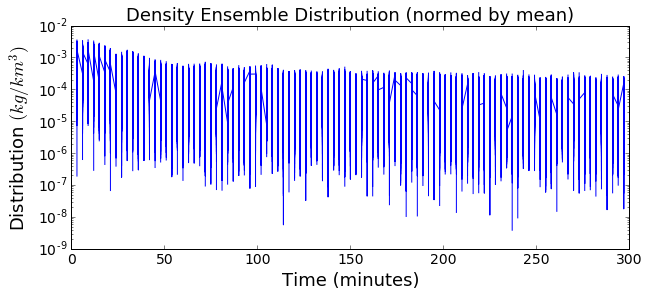

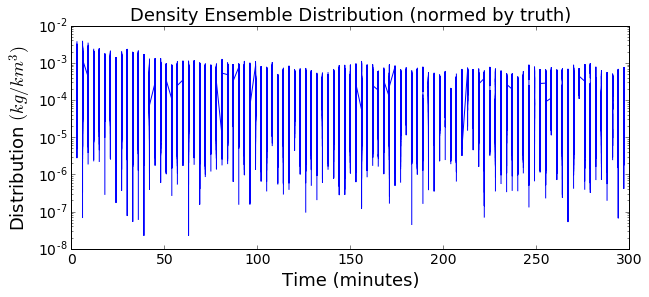

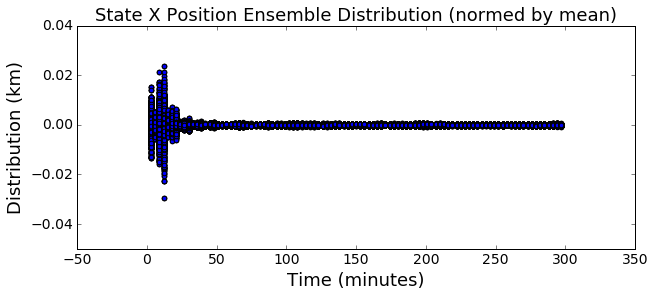

In [144]:
times = measurement_array[:stop_index, 0]/(60)

time_str = 'Time (minutes)'

time_repeated_ensemble = np.repeat(times[:stop_index], num_of_ensembles)
time_repeated_X = np.repeat(times[:stop_index], num_of_ensembles)

#"""
#calculate the normed density distribution by subtracting the mean of the ensemble from each ensemble   
#density_distribution shape = num_of_ensembles x stop_index
density_distribution_mean = np.mean(density_distribution[:,:stop_index], axis=0).reshape(1, stop_index)

density_distribution_mean_tiled = np.tile(density_distribution_mean, (1, num_of_ensembles))
density_distribution_mean_tiled = density_distribution_mean_tiled.reshape(num_of_ensembles, stop_index)

density_distribution_normed = density_distribution[:, :stop_index] - density_distribution_mean_tiled


fig, ax = plt.subplots()
ax.semilogy(time_repeated_ensemble, density_distribution_normed.T.flatten())
#plt.scatter(time_repeated_ensemble, density_distribution_normed.T.flatten())
plt.ylabel(r'Distribution $(kg/km^3)$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim(-.5e-3, .5e-3)
plt.title('Density Ensemble Distribution (normed by mean)', fontsize=18)
plt.show()



#calculate the normed density distribution by subtracting the truth of the ensemble from each ensemble   
#density_distribution shape = num_of_ensembles x stop_index
true_density_array = truth_xyz[:,-1]
density_distribution_truth = true_density_array[:stop_index].reshape(1, stop_index)
density_distribution_normed = density_distribution[:, :stop_index] - \
                    np.tile(density_distribution_truth, (num_of_ensembles, 1))

fig_dens_dist, ax = plt.subplots()
ax.semilogy(time_repeated_ensemble, density_distribution_normed.T.flatten())
#plt.scatter(time_repeated_ensemble, density_distribution_normed.T.flatten())
plt.ylabel(r'Distribution $(kg/km^3)$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim(-1e-3, 1e-3)
plt.title('Density Ensemble Distribution (normed by truth)', fontsize=18)
plt.show()
#"""

#calculate the normed X pos distribution by subtracting the mean of the ensemble from each ensemble   
#X_distribution shape = 6 x num_of_ensembles x stop_index
X_distribution_Xpos = X_distribution[0,:,:stop_index]
X_distribution_Xpos_mean = np.mean(X_distribution_Xpos, axis=0).reshape(1, stop_index)
X_distribution_Xpos_mean_tiled = np.tile(X_distribution_Xpos_mean, (1, num_of_ensembles))
X_distribution_Xpos_mean_tiled = X_distribution_Xpos_mean_tiled.reshape(num_of_ensembles, stop_index)
X_distribution_Xpos_diff = X_distribution_Xpos - X_distribution_Xpos_mean_tiled

fig_X_dist = plt.figure()
plt.scatter(time_repeated_X, X_distribution_Xpos_diff.T.flatten())
plt.ylabel(r'Distribution (km)', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim(-1e-4,1e-4)
plt.title('State X Position Ensemble Distribution (normed by mean)', fontsize=18)
plt.show()


''' not normed by correct truth because truth time series is for different objects
#calculate the normed X pos distribution by subtracting the truth of the ensemble from each ensemble   
#X_distribution shape = 6 x num_of_ensembles x stop_index
X_distribution_Xpos_truth = truth_xyz[:stop_index, 0].reshape(1, stop_index)
X_distribution_Xpos_truth_normed = X_distribution_Xpos - np.tile(X_distribution_Xpos_truth, (num_of_ensembles, 1))

fig_X_dist = plt.figure()
plt.scatter(time_repeated_ensemble, X_distribution_Xpos_truth_normed.T.flatten())
plt.ylabel(r'Distribution (km)', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim(-1e-4, 1e-4)
plt.title('State X Position Ensemble Distribution (normed by truth)', fontsize=18)
plt.show()
'''


if saveFig_bool:
    fig_dens_dist.savefig('Figures/dens_dist.png')
    fig_X_dist.savefig('Figures/fig_X_dist.png')


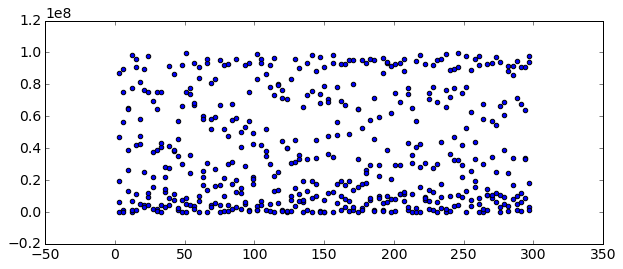

In [145]:

times = measurement_array[:stop_index, 0]/(60)
plt.scatter(times, xpos_info_array)


In [146]:

diff = np.absolute(X_mean_updated_list_EnKF[:stop_index, -1] - \
                                               true_density_array[:stop_index])
#plt.plot(times, diff)
#print(X_mean_updated_list_EnKF[:stop_index, -1])
#true_density_array[:stop_index]

stop = stop_index
#plt.scatter(measurement_array[:stop, 2], perc_error[:stop])
#plt.scatter(measurement_array[:stop_index, 1], perc_error)
perc_error
#measurement_array[:stop_index, 0]/60

array([  5.798890194299422,   5.404063543516818,   5.421463717639729,
         5.342343113634911,   3.586955139082476,   8.278005407447672,
         0.953748480436949,   2.115041898753396,   8.447303177133524,
         2.831696064824742,   0.088477616831085,  12.07341621490224 ,
         1.168561037576233,   3.124303005165242,   5.217361430992098,
         3.687259089062793,   1.160003527820863,   7.589906207967276,
         4.211270806794642,  10.015551082155632,   6.310313082798422,
        12.334233727585435,   3.924573222732509,   9.215956125833957,
         6.195974566575737,   2.972103679048987,  10.633300603781885,
         1.718786167956563,   3.213777107731322,   5.91724138758419 ,
         4.227527112409338,   8.925213719611726,   8.989846448599801,
         0.544936237958276,  16.894099700823269,   0.219876610290836,
         5.511772088875793,   8.190053365996267,   3.297040152289251,
         7.880919161106723,   2.601375652706528,   6.662768709262214,
         4.350906036

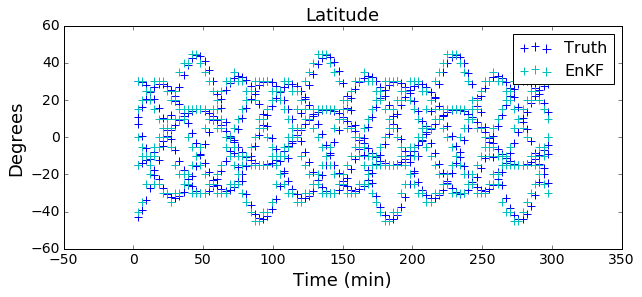

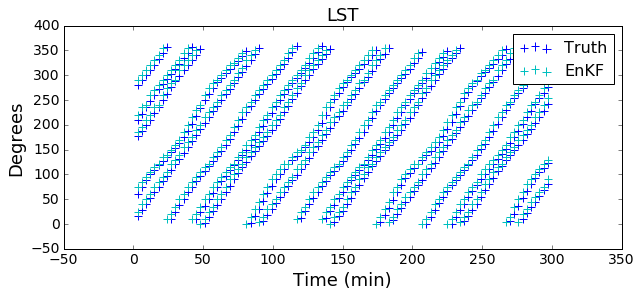

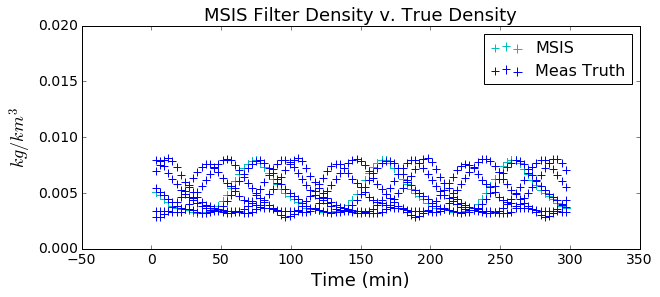

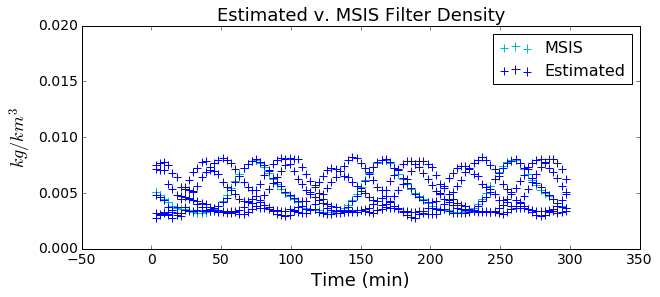

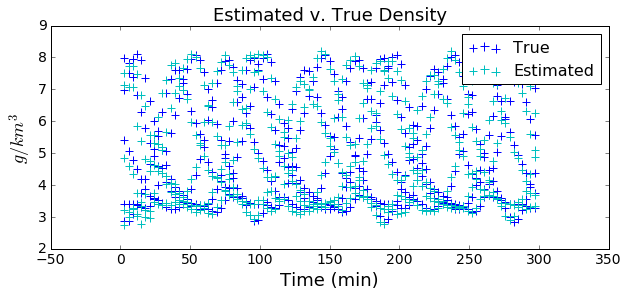

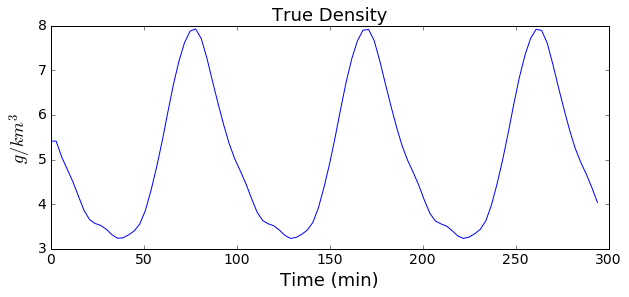

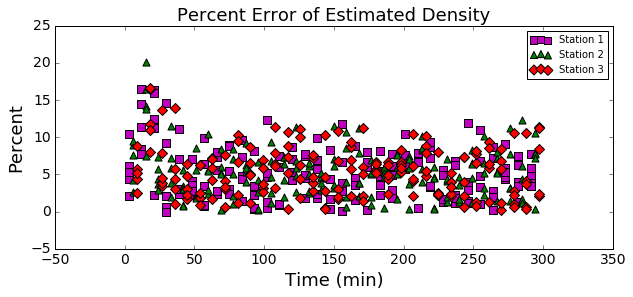

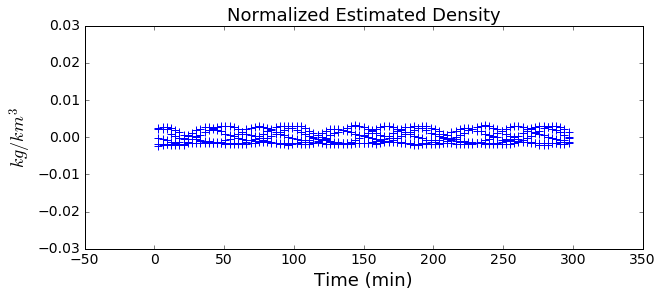

In [147]:


time_str = 'Time (min)'


times = measurement_array[:stop_index, 0]/(60)

time_repeated_ensemble = np.repeat(times[:stop_index], num_of_ensembles)
time_repeated_X = np.repeat(times[:stop_index], num_of_ensembles)


indices_1 = np.where(measurement_array[:stop_index, 1] == 1)[0]
indices_2 = np.where(measurement_array[:stop_index, 1] == 2)[0]
indices_3 = np.where(measurement_array[:stop_index, 1] == 3)[0]
indices_4 = np.where(measurement_array[:stop_index, 1] == 4)[0]


#sort by object so that results show all results for one object and then
indices = np.argsort(measurement_array[:stop_index,2], axis=0) 


fig_lat = plt.figure()
plt.scatter(times, np.degrees(lat_lst_meas_array[:stop_index, 0]), s=70, c='b',marker='+')
plt.scatter(times, np.degrees(lat_lst_array[0,:stop_index]), s=70, c='c',marker='+')
plt.ylabel('Degrees', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('Latitude', fontsize=18)
legend_names = ['Truth', 'EnKF']
plt.legend(legend_names, fontsize=16)
plt.show()

#print(np.degrees(lat_lst_meas_array[:stop_index, 0] - lat_lst_array[0,:stop_index]))



fig_LST = plt.figure()
plt.scatter(times, np.degrees(lat_lst_meas_array[:stop_index, 1]), s=70, c='b', marker='+')
plt.scatter(times, np.degrees(lat_lst_array[1,:stop_index]), s=70, c='c', marker='+')
plt.ylabel('Degrees', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('LST', fontsize=18)
legend_names = ['Truth', 'EnKF']
plt.legend(legend_names, fontsize=16)
plt.show()

#print(np.degrees(lat_lst_meas_array[:stop_index, 1][indices] - lat_lst_array[1,:stop_index][indices]))


fig_density_comparison = plt.figure()
plt.scatter(times, density_MSIS_array[:stop_index], s=70, c='c', marker='+')
plt.scatter(times, true_density_array[:stop_index], s=70, c='b', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim([0,2e-2])
plt.title('MSIS Filter Density v. True Density', fontsize=18)
legend_names = ['MSIS', 'Meas Truth']
plt.legend(legend_names, fontsize=16)
plt.show()


fig_density_comparison = plt.figure()
plt.scatter(times, density_MSIS_array[:stop_index], s=70, c='c', marker='+')
plt.scatter(times, X_mean_updated_list_EnKF[:stop_index, -1], s=70, c='b', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim([0,2e-2])
plt.title('Estimated v. MSIS Filter Density', fontsize=18)
legend_names = ['MSIS', 'Estimated']
plt.legend(legend_names, fontsize=16)
plt.show()




fig_density_comparison = plt.figure()
plt.scatter(times, true_density_array[:stop_index] * 1e3, s=70, c='b', marker='+')
plt.scatter(times, X_mean_updated_list_EnKF[:stop_index, -1] * 1e3, s=70, c='c', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel(r'$g/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim([0,2e-2])
plt.title('Estimated v. True Density', fontsize=18)
legend_names = ['True', 'Estimated']
plt.legend(legend_names, fontsize=16)
plt.show()


stopp = TU_array_length + initial_sim_index
fig_true_density = plt.figure()
plt.plot(true_state_all_times[:stopp,0]/60, true_state_all_times[:stopp,-1] * 1e3)
plt.ylabel(r'$g/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim([0,2e-2])
plt.title('True Density', fontsize=18)
plt.show()



perc_error = 100 * np.absolute(X_mean_updated_list_EnKF[:stop_index, -1] - \
                                               true_density_array[:stop_index])/true_density_array[:stop_index]

fig_percent = plt.figure()
plt.scatter(times[indices_1], perc_error[indices_1], s=50, c='m', marker='s')
plt.scatter(times[indices_2], perc_error[indices_2], s=50, c='g', marker='^')
plt.scatter(times[indices_3], perc_error[indices_3], s=50, c='r', marker='D')
plt.scatter(times[indices_4], perc_error[indices_4], s=50, c='k', marker='o')
#plt.ylim([0,200])
plt.ylabel('Percent', fontsize=18)
legend_names = ['Station 1', 'Station 2', 'Station 3']
plt.legend(legend_names, fontsize=10)
plt.xlabel(time_str, fontsize=18)
plt.title('Percent Error of Estimated Density', fontsize=18)
plt.show()





mean = np.mean(X_mean_updated_list_EnKF[:stop_index, -1])
est_density_array_normalized = X_mean_updated_list_EnKF[:stop_index, -1] - mean

fig_est = plt.figure()
plt.scatter(times, est_density_array_normalized[:stop_index], s=70, c='b', marker='+')
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('Normalized Estimated Density', fontsize=18)
plt.show()



if saveFig_bool:
    fig_lat.savefig('Figures/latitude.png')
    fig_LST.savefig('Figures/LST.png')
    fig_density_comparison.savefig('Figures/density_comparison.png')
    fig_percent.savefig('Figures/percent.png')
    fig_est.savefig('Figures/est_density.png')
    fig_true_density.savefig('Figures/true_density.png')


[  63.   66.  129.  141.  144.  159.  180.  183.  204.  240.  243.  282.]
60


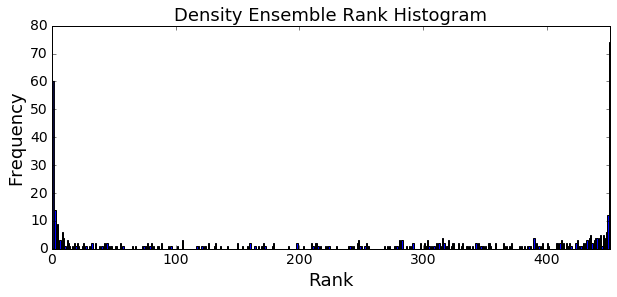

In [148]:
# Rank Histograms


#Density

rank_array = np.zeros((stop_index, 1))

for ii in range(stop_index):
    
    new_array = np.append(density_distribution[:, ii], true_density_array[ii])
    
    rank = scipy.stats.rankdata(new_array, method='min')[-1]
    
    rank_array[ii] = rank
    
indices = np.where(rank_array == 1)[0]
indices1 = np.where(rank_array == 450)[0]
print(times[indices1])
print(len(indices))



fig_rank_hist = plt.figure()
plt.hist(rank_array, bins=451)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Rank', fontsize=18)
plt.title('Density Ensemble Rank Histogram', fontsize=18)
plt.xlim([0,451])
plt.show()

fig_rank_hist.savefig('Figures/rank_hist.png')




In [149]:
rank_array

array([[ 332.],
       [ 242.],
       [ 281.],
       [ 301.],
       [ 292.],
       [ 324.],
       [ 230.],
       [ 221.],
       [ 349.],
       [ 305.],
       [ 283.],
       [ 224.],
       [ 303.],
       [ 321.],
       [ 287.],
       [ 311.],
       [ 324.],
       [ 401.],
       [ 370.],
       [ 317.],
       [ 387.],
       [ 302.],
       [ 392.],
       [ 355.],
       [ 397.],
       [ 382.],
       [ 313.],
       [ 385.],
       [ 411.],
       [ 340.],
       [ 408.],
       [ 329.],
       [ 433.],
       [ 351.],
       [ 210.],
       [ 336.],
       [ 409.],
       [ 169.],
       [ 277.],
       [ 158.],
       [ 289.],
       [  76.],
       [ 301.],
       [  55.],
       [ 323.],
       [  45.],
       [ 217.],
       [ 213.],
       [  74.],
       [ 256.],
       [ 255.],
       [ 353.],
       [ 105.],
       [  42.],
       [ 160.],
       [ 247.],
       [  24.],
       [  73.],
       [ 292.],
       [ 132.],
       [ 160.],
       [ 172.],
       [

In [150]:
def calc_display_results_pre(pre_fit_list, prefit_bounds_list, measurement_array, R, meas_type, stop_index, \
                             saveFig_bool, time_str):
    
    
    rms_1 = 'Range ='
    unit_1 = 'km'
    ylabel_1 = 'Range Residuals (km)'
    title_1 = 'Range Pre-fit Residuals'
    save_fig_1 = 'prefit_range.png'
    rms_2 = 'Range Rate ='
    unit_2 = 'km/s'
    ylabel_2 = 'Range Rate Residuals (km/s)'
    title_2 = 'Range Rate Pre-fit Residuals'
    save_fig_2 = 'prefit_rangeRate.png'
    pre_fit_list_new = copy.deepcopy(pre_fit_list)
         
    if (meas_type == 2) or (meas_type == 3):
        rms_1 = 'Azimuth ='
        unit_1 = 'degrees'
        rms_2 = 'Elevation ='
        unit_2 = 'degrees'
        pre_fit_list_new[:, 0] = np.degrees(pre_fit_list[:, 0])
        pre_fit_list_new[:, 1] = np.degrees(pre_fit_list[:, 1])
        ylabel_1 = 'Azimuth Residuals (degrees)'
        title_1 = 'Azimuth Pre-fit Residuals'
        save_fig_1 = 'prefit_az.png'
        ylabel_2 = 'Elevation Residuals (degrees)'
        title_2 = 'Elevation Pre-fit Residuals'
        save_fig_2 = 'prefit_el_rate.png'

        
    

    times = measurement_array[:stop_index,0]/(60)
    
    indices_1 = np.where(measurement_array[:stop_index, 1] == 1)[0]
    indices_2 = np.where(measurement_array[:stop_index, 1] == 2)[0]
    indices_3 = np.where(measurement_array[:stop_index, 1] == 3)[0]

    
    
    #pre-fit
    print('pre-fit RMS:')
    pre_fit_1_list_4RMS = pre_fit_list_new[:, 0]
    prefit_1_rms = np.sqrt(np.mean(np.square(pre_fit_1_list_4RMS)))
    print(rms_1, "%.4f" % prefit_1_rms, unit_1)

    pre_fit_2_list_4RMS = pre_fit_list_new[:, 1]
    prefit_2_rms = np.sqrt(np.mean(np.square(pre_fit_2_list_4RMS)))
    print(rms_2, "%.4f" % prefit_2_rms, unit_2)
    
    if meas_type == 3:
        pre_fit_3_list_4RMS = pre_fit_list_new[:, 2]
        prefit_3_rms = np.sqrt(np.mean(np.square(pre_fit_3_list_4RMS)))
        print('Range =', "%.3f" % prefit_3_rms, 'km')
    
    
    covar_env_upper1 = np.degrees(abs(prefit_bounds_list[:stop_index, 0]))*3
    covar_env_upper2 = np.degrees(abs(prefit_bounds_list[:stop_index, 1]))*3

   
    #pre-fit Residuals
    fig_preFit_az = plt.figure()
    plt.plot(times, covar_env_upper1, label='_nolegend_', c='g')
    plt.plot(times, -covar_env_upper1, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], pre_fit_list_new[indices_1, 0], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], pre_fit_list_new[indices_2, 0], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], pre_fit_list_new[indices_3, 0], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], pre_fit_list_new[indices_4, 0], s=50, c='k', marker='o')
    plt.ylabel(ylabel_1, fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.title(title_1, fontsize=18)
    legend_names = ['Station 1', 'Station 2', 'Station 3']
    plt.legend(legend_names, fontsize=10)
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.tight_layout()
    plt.show()
    #fig.savefig(save_fig_1)

    fig_preFit_el = plt.figure()
    plt.plot(times, covar_env_upper2, label='_nolegend_', c='g')
    plt.plot(times, -covar_env_upper2, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], pre_fit_list_new[indices_1, 1], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], pre_fit_list_new[indices_2, 1], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], pre_fit_list_new[indices_3, 1], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], pre_fit_list_new[indices_4, 1], s=50, c='k', marker='o')
    plt.ylabel(ylabel_2, fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.title(title_2, fontsize=18)
    plt.legend(legend_names, fontsize=10)
    #plt.ylim([-.01,.01])
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.tight_layout()
    plt.show()
    #fig.savefig(save_fig_2)
    
    if meas_type == 3:
        
        covar_env_upper3 = abs(prefit_bounds_list[:stop_index, 2])*3
        
        fig_preFit_range = plt.figure()
        plt.plot(times, covar_env_upper3, label='_nolegend_', c='g')
        plt.plot(times, -covar_env_upper3, label='_nolegend_', c='g')
        plt.scatter(times[indices_1], pre_fit_list_new[indices_1, 2], s=50, c='m', marker='s')
        plt.scatter(times[indices_2], pre_fit_list_new[indices_2, 2], s=50, c='g', marker='^')
        plt.scatter(times[indices_3], pre_fit_list_new[indices_3, 2], s=50, c='r', marker='D')
        plt.scatter(times[indices_4], pre_fit_list_new[indices_4, 2], s=50, c='k', marker='o')
        plt.ylabel('Range Residuals (km)', fontsize=18)
        plt.xlabel(time_str, fontsize=18)
        plt.title('Range Pre-fit Residuals', fontsize=18)
        plt.legend(legend_names, fontsize=10)
        #plt.ylim([-.01,.01])
        plt.xlim([times[0] - 5, times[-1] + 5])
        plt.tight_layout()
        plt.show()
        #fig.savefig('prefit_range.png')
    
    if saveFig_bool:
        fig_preFit_az.savefig('Figures/preFit_az.png')
        fig_preFit_el.savefig('Figures/preFit_el.png')
        fig_preFit_range.savefig('Figures/preFit_range.png')
        
        
def calc_display_results(post_fit_list, measurement_array, R, meas_type, stop_index, saveFig_bool, time_str):
    
    
    rms_1 = 'Range ='
    unit_1 = 'km'
    ylabel_1 = 'Range Residuals (km)'
    title_1 = 'Range Post-fit Residuals'
    save_fig_1 = 'postfit_range.png'
    rms_2 = 'Range Rate ='
    unit_2 = 'km/s'
    ylabel_2 = 'Range Rate Residuals (km/s)'
    title_2 = 'Range Rate Post-fit Residuals'
    save_fig_2 = 'postfit_rangeRate.png'
    post_fit_list_new = copy.deepcopy(post_fit_list)
         
    if (meas_type == 2) or (meas_type == 3):
        rms_1 = 'Azimuth ='
        unit_1 = 'degrees'
        rms_2 = 'Elevation ='
        unit_2 = 'degrees'
        post_fit_list_new[:, 0] = np.degrees(post_fit_list[:, 0])
        post_fit_list_new[:, 1] = np.degrees(post_fit_list[:, 1])
        ylabel_1 = 'Azimuth Residuals (degrees)'
        title_1 = 'Azimuth Post-fit Residuals'
        save_fig_1 = 'postfit_az.png'
        ylabel_2 = 'Elevation Residuals (degrees)'
        title_2 = 'Elevation Post-fit Residuals'
        save_fig_2 = 'postfit_el_rate.png'

        
    

    times = measurement_array[:stop_index,0]/(60)
    
    indices_1 = np.where(measurement_array[:stop_index, 1] == 1)[0]
    indices_2 = np.where(measurement_array[:stop_index, 1] == 2)[0]
    indices_3 = np.where(measurement_array[:stop_index, 1] == 3)[0]
    indices_4 = np.where(measurement_array[:stop_index, 1] == 4)[0]

    
    
    #Post-fit
    print('Post-fit RMS:')
    post_fit_1_list_4RMS = post_fit_list_new[:, 0]
    postfit_1_rms = np.sqrt(np.mean(np.square(post_fit_1_list_4RMS)))
    print(rms_1, "%.4f" % postfit_1_rms, unit_1)

    post_fit_2_list_4RMS = post_fit_list_new[:, 1]
    postfit_2_rms = np.sqrt(np.mean(np.square(post_fit_2_list_4RMS)))
    print(rms_2, "%.4f" % postfit_2_rms, unit_2)
    
    if meas_type == 3:
        post_fit_3_list_4RMS = post_fit_list_new[:, 2]
        postfit_3_rms = np.sqrt(np.mean(np.square(post_fit_3_list_4RMS)))
        print('Range =', "%.5f" % postfit_3_rms, 'km')
    
    
    covar_env_upper1 = np.ones((stop_index)) * np.degrees(np.sqrt(abs(R[0, 0])))*3
    covar_env_upper2 = np.ones((stop_index)) * np.degrees(np.sqrt(abs(R[1, 1])))*3

   
    #Post-fit Residuals
    fig_postFit_az = plt.figure()
    plt.plot(times, covar_env_upper1, label='_nolegend_', c='g')
    plt.plot(times, -covar_env_upper1, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], post_fit_list_new[indices_1, 0], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], post_fit_list_new[indices_2, 0], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], post_fit_list_new[indices_3, 0], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], post_fit_list_new[indices_4, 0], s=50, c='k', marker='o')
    plt.ylabel(ylabel_1, fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.title(title_1, fontsize=18)
    legend_names = ['Station 1', 'Station 2', 'Station 3']
    plt.legend(legend_names, fontsize=10)
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.tight_layout()
    plt.show()
    #fig.savefig(save_fig_1)

    fig_postFit_el = plt.figure()
    plt.plot(times, covar_env_upper2, label='_nolegend_', c='g')
    plt.plot(times, -covar_env_upper2, label='_nolegend_', c='g')
    plt.scatter(times[indices_1], post_fit_list_new[indices_1, 1], s=50, c='m', marker='s')
    plt.scatter(times[indices_2], post_fit_list_new[indices_2, 1], s=50, c='g', marker='^')
    plt.scatter(times[indices_3], post_fit_list_new[indices_3, 1], s=50, c='r', marker='D')
    plt.scatter(times[indices_4], post_fit_list_new[indices_4, 1], s=50, c='k', marker='o')
    plt.ylabel(ylabel_2, fontsize=18)
    plt.xlabel(time_str, fontsize=18)
    plt.title(title_2, fontsize=18)
    plt.legend(legend_names, fontsize=10)
    #plt.ylim([-.01,.01])
    plt.xlim([times[0] - 5, times[-1] + 5])
    plt.tight_layout()
    plt.show()
    #fig.savefig(save_fig_2)
    
    if meas_type == 3:
        
        covar_env_upper3 = np.ones((stop_index)) * np.sqrt(abs(R[2, 2]))*3
        
        fig_postFit_range = plt.figure()
        plt.plot(times, covar_env_upper3, label='_nolegend_', c='g')
        plt.plot(times, -covar_env_upper3, label='_nolegend_', c='g')
        plt.scatter(times[indices_1], post_fit_list_new[indices_1, 2], s=50, c='m', marker='s')
        plt.scatter(times[indices_2], post_fit_list_new[indices_2, 2], s=50, c='g', marker='^')
        plt.scatter(times[indices_3], post_fit_list_new[indices_3, 2], s=50, c='r', marker='D')
        plt.scatter(times[indices_4], post_fit_list_new[indices_4, 2], s=50, c='k', marker='o')
        plt.ylabel('Range Residuals (km)', fontsize=18)
        plt.xlabel(time_str, fontsize=18)
        plt.title('Range Post-fit Residuals', fontsize=18)
        legend_names = ['Station 1', 'Station 2']
        plt.legend(legend_names, fontsize=10)
        #plt.ylim([-.01,.01])
        plt.xlim([times[0] - 5, times[-1] + 5])
        plt.tight_layout()
        plt.show()
        #fig.savefig('postfit_range.png')
    
    if saveFig_bool:
        fig_postFit_az.savefig('Figures/postFit_az.png')
        fig_postFit_el.savefig('Figures/postFit_el.png')
        fig_postFit_range.savefig('Figures/postFit_range.png')
        
    
    
def plot_error_covar_xref(P_list, x_ref_updated_list, x_ref_TU_list, obs_data_truth, density_truth, density_range, x_range, y_range, \
                          z_range, xv_range, yv_range, zv_range, measurement_array, time, stop_index, \
                          saveFig_bool, time_str, title_str, num_of_objects):
    
    
    times = time[:stop_index]/(60)
    
    initial_filter_index = initial_sim_index + 1
    


    indices_1 = np.where(measurement_array[:stop_index, 1] == 1)[0]
    indices_2 = np.where(measurement_array[:stop_index, 1] == 2)[0]
    indices_3 = np.where(measurement_array[:stop_index, 1] == 3)[0]
    
    
    
    density_covar_env_upper = np.sqrt(abs(P_list[:stop_index, -1, -1]))*3
    density_covar_env_lower = -density_covar_env_upper
    density_error = x_ref_updated_list[:stop_index,-1] - density_truth[:stop_index]
        
    
    #error_pos_norm = np.sqrt(x_error**2 + y_error**2 + z_error**2)
    error_density_rms_3D = np.sqrt(np.mean(np.square(density_error))) * 1e3
    print('Density RMS =', "%.5f" % error_density_rms_3D, r'$(g/km^3)$')
    
    

    
    for ii in range(num_of_objects):
        
        
        
        #based on object ID, calculate indices in the state for this update
        ID = ii + 1
        obj_index_begin = (ID-1)*6
        obj_index_end = ID*6 - 1
        object_num = ID
        
        
        x_pos_index = obj_index_begin
        y_pos_index = obj_index_begin + 1
        z_pos_index = obj_index_begin + 2
        x_vel_index = obj_index_begin + 3 
        y_vel_index = obj_index_begin + 4
        z_vel_index = obj_index_begin + 5
       
        
        
        
        #prep all times (including no-measurement times) results
        ind = np.where(true_state_all_times[:,1] == ID)
        true_all_sim_times = true_state_all_times[ind][(initial_filter_index):(initial_filter_index+TU_array_length),:]

        true_dens = true_all_sim_times[:,-1]

        times_TU = true_all_sim_times[:,0]/60

        density_error_TU = x_ref_TU_list[:,(prob_dimension+ii)] - true_dens
        
        indices_1 = np.where(measurement_array[:stop_index, 1] == 1)[0]
        indices_2 = np.where(measurement_array[:stop_index, 1] == 2)[0]
        indices_3 = np.where(measurement_array[:stop_index, 1] == 3)[0]
        

        #Density
        fig_dens = plt.figure()
        plt.scatter(times_TU, density_error_TU * 1e3, label='_nolegend_', s=20, c='k', marker='.')
        plt.plot(times, density_covar_env_upper * 1e3, label='_nolegend_', c='g')
        plt.plot(times, density_covar_env_lower * 1e3, label='_nolegend_', c='g')
        plt.scatter(times[indices_1], density_error[indices_1]* 1e3, s=50, c='m', marker='s')
        plt.scatter(times[indices_2], density_error[indices_2]* 1e3, s=50, c='g', marker='^')
        plt.scatter(times[indices_3], density_error[indices_3]* 1e3, s=50, c='r', marker='D')
        plt.scatter(times[indices_4], density_error[indices_4]* 1e3, s=50, c='k', marker='o')
        plt.ylabel(r'$(g/km^3)$', fontsize=18)
        plt.xlabel(time_str, fontsize=18)
        legend_names = ['Station 1', 'Station 2', 'Station 3']
        plt.legend(legend_names, fontsize=10)
        plt.title('Obj ' + str(object_num) + ' ' + title_str + ' Density Error & Covariance Envelope', fontsize=18)
        plt.ylim([-density_range,density_range])
        plt.xlim([times[0] - 5, times[-1] + 5])
        plt.show()
        
        
        
        #find this object's results
        indices = np.where(true_state_all_times[:,1] == ID)[0]  
        true_state_all_times_thisObj = true_state_all_times[np.r_[indices,:]]
        
        true_all_sim_times_thisObj = true_state_all_times_thisObj\
                            [(initial_filter_index):(initial_filter_index+TU_array_length),:]
        
        times_all = true_state_all_times_thisObj[(initial_filter_index):(initial_filter_index+TU_array_length),0]/60
        

        x_error_all = x_ref_TU_list[:,x_pos_index] - true_all_sim_times_thisObj[:,2]
        y_error_all = x_ref_TU_list[:,y_pos_index] - true_all_sim_times_thisObj[:,3]
        z_error_all = x_ref_TU_list[:,z_pos_index] - true_all_sim_times_thisObj[:,4]
        x_vel_error_all = x_ref_TU_list[:,x_vel_index] - true_all_sim_times_thisObj[:,5]
        y_vel_error_all = x_ref_TU_list[:,y_vel_index] - true_all_sim_times_thisObj[:,6]
        z_vel_error_all = x_ref_TU_list[:,z_vel_index] - true_all_sim_times_thisObj[:,7]
        
        
        
        indices_obj = np.where(measurement_array[:stop_index, 2] == ID)[0]
        
        if len(indices_obj) != 0:
        
            indices_1 = np.where(measurement_array[:stop_index, 1][np.r_[indices_obj]] == 1)[0]
            indices_2 = np.where(measurement_array[:stop_index, 1][np.r_[indices_obj]] == 2)[0]
            indices_3 = np.where(measurement_array[:stop_index, 1][np.r_[indices_obj]] == 3)[0]

            times_obj = times[:stop_index][np.r_[indices_obj]]


            #Compare to the Truth Data : Estimation Errors------

            x_covar_env_upper = np.sqrt(abs(P_list[:stop_index, x_pos_index, x_pos_index]))*3
            x_covar_env_lower = -x_covar_env_upper
            x_error = x_ref_updated_list[:stop_index,x_pos_index][np.r_[indices_obj]] - \
                                obs_data_truth[:stop_index, 0][np.r_[indices_obj]]
        

            y_covar_env_upper = np.sqrt(abs(P_list[:stop_index, y_pos_index, y_pos_index]))*3
            y_covar_env_lower = -y_covar_env_upper
            y_error = x_ref_updated_list[:stop_index,y_pos_index][np.r_[indices_obj]] - \
                                 obs_data_truth[:stop_index, 1][np.r_[indices_obj]]

            z_covar_env_upper = np.sqrt(abs(P_list[:stop_index, z_pos_index, z_pos_index]))*3
            z_covar_env_lower = -z_covar_env_upper
            z_error = x_ref_updated_list[:stop_index,z_pos_index][np.r_[indices_obj]] - \
                                 obs_data_truth[:stop_index, 2][np.r_[indices_obj]]

            

            print('~~Obj ' + str(object_num) + ' Results~~')
            print('Position RMS:')
            error_x_pos_rms_3D = np.sqrt(np.mean(np.square(x_error)))
            print('X =', "%.4f" % error_x_pos_rms_3D, 'km')

            error_y_pos_rms_3D = np.sqrt(np.mean(np.square(y_error)))
            print('Y =', "%.4f" % error_y_pos_rms_3D, 'km')

            error_z_pos_rms_3D = np.sqrt(np.mean(np.square(z_error)))
            print('Z =', "%.4f" % error_z_pos_rms_3D, 'km')

            pos_rms = np.sqrt(error_x_pos_rms_3D**2 + error_y_pos_rms_3D**2 + error_z_pos_rms_3D**2)
            print('Overall =', "%.4f" % pos_rms, 'km')

            #x Velocity
            x_dot_covar_env_upper = np.sqrt(abs(P_list[:stop_index, x_vel_index, x_vel_index]))*3
            x_dot_covar_env_lower = -x_dot_covar_env_upper
            x_vel_error = x_ref_updated_list[:stop_index,x_vel_index][np.r_[indices_obj]]\
                                        - obs_data_truth[:stop_index, 3][np.r_[indices_obj]]

            #y Velocity
            y_dot_covar_env_upper = np.sqrt(abs(P_list[:stop_index, y_vel_index, y_vel_index]))*3
            y_dot_covar_env_lower = -y_dot_covar_env_upper
            y_vel_error = x_ref_updated_list[:stop_index,y_vel_index][np.r_[indices_obj]]\
                                        - obs_data_truth[:stop_index, 4][np.r_[indices_obj]]        

            #z Velocity
            z_dot_covar_env_upper = np.sqrt(abs(P_list[:stop_index, z_vel_index, z_vel_index]))*3
            z_dot_covar_env_lower = -z_dot_covar_env_upper
            z_vel_error = x_ref_updated_list[:stop_index,z_vel_index][np.r_[indices_obj]]\
                                        - obs_data_truth[:stop_index, 5][np.r_[indices_obj]]       

            print('\nVelocity RMS:')
            error_x_vel_rms_3D = np.sqrt(np.mean(np.square(x_vel_error)))
            print('X =', "%.6f" % error_x_vel_rms_3D, 'km/second')

            error_y_vel_rms_3D = np.sqrt(np.mean(np.square(y_vel_error)))
            print('Y =', "%.6f" % error_y_vel_rms_3D, 'km/second')

            error_z_vel_rms_3D = np.sqrt(np.mean(np.square(z_vel_error)))
            print('Z =', "%.6f" % error_z_vel_rms_3D, 'km/second')

            vel_rms = np.sqrt(error_x_vel_rms_3D**2 + error_y_vel_rms_3D**2 + error_z_vel_rms_3D**2)
            print('Overall =', "%.6f" % vel_rms, 'km/s')



            #x Position
            fig_xpos = plt.figure()
            plt.scatter(times_all, x_error_all, label='_nolegend_', s=50, c='k', marker='.')
            plt.plot(times, x_covar_env_upper, label='_nolegend_', c='g')
            plt.plot(times, x_covar_env_lower, label='_nolegend_', c='g')
            plt.scatter(times_obj[indices_1], x_error[indices_1], s=50, c='m', marker='s')
            plt.scatter(times_obj[indices_2], x_error[indices_2], s=50, c='g', marker='^')
            plt.scatter(times_obj[indices_3], x_error[indices_3], s=50, c='r', marker='D')
            plt.scatter(times_obj[indices_4], x_error[indices_4], s=50, c='k', marker='o')
            plt.ylabel('km', fontsize=18)
            plt.xlabel(time_str, fontsize=18)
            plt.legend(legend_names, fontsize=10)
            plt.title('Obj ' + str(object_num) + ' ' + title_str + ' X Position Error & Covariance Envelope', fontsize=18)
            plt.ylim([-x_range,x_range])
            plt.xlim([times[0] - 5, times[-1] + 5])
            plt.show()

            #y Position 
            fig_ypos = plt.figure()
            plt.scatter(times_all, y_error_all, label='_nolegend_', s=50, c='k', marker='.')
            plt.plot(times, y_covar_env_upper, label='_nolegend_', c='g')
            plt.plot(times, y_covar_env_lower, label='_nolegend_', c='g')
            plt.scatter(times_obj[indices_1], y_error[indices_1], s=50, c='m', marker='s')
            plt.scatter(times_obj[indices_2], y_error[indices_2], s=50, c='g', marker='^')
            plt.scatter(times_obj[indices_3], y_error[indices_3], s=50, c='r', marker='D')
            plt.scatter(times_obj[indices_4], y_error[indices_4], s=50, c='k', marker='o')
            plt.ylabel('km', fontsize=18)
            plt.xlabel(time_str, fontsize=18)
            plt.legend(legend_names, fontsize=10)
            plt.title('Obj ' + str(object_num) + ' ' + title_str + ' Y Position Error & Covariance Envelope', \
                      fontsize=18)
            plt.ylim([-y_range,y_range])
            plt.xlim([times[0] - 5, times[-1] + 5])
            plt.show()
            #fig.savefig('y_pos_error.png')

            #z Position
            fig_zpos = plt.figure()
            plt.scatter(times_all, z_error_all, label='_nolegend_', s=50, c='k', marker='.')
            plt.plot(times, z_covar_env_upper, label='_nolegend_', c='g')
            plt.plot(times, z_covar_env_lower, label='_nolegend_', c='g')
            plt.scatter(times_obj[indices_1], z_error[indices_1], s=50, c='m', marker='s')
            plt.scatter(times_obj[indices_2], z_error[indices_2], s=50, c='g', marker='^')
            plt.scatter(times_obj[indices_3], z_error[indices_3], s=50, c='r', marker='D')
            plt.scatter(times_obj[indices_4], z_error[indices_4], s=50, c='k', marker='o')
            plt.ylabel('km', fontsize=18)
            plt.xlabel(time_str, fontsize=18)
            plt.legend(legend_names, fontsize=10)
            plt.title('Obj ' + str(object_num) + ' ' + title_str + ' Z Position Error & Covariance Envelope', \
                      fontsize=18)
            plt.ylim([-z_range,z_range])
            plt.xlim([times[0] - 5, times[-1] + 5])
            plt.show()



            fig_xvel = plt.figure()
            plt.scatter(times_all, x_vel_error_all, label='_nolegend_', s=50, c='k', marker='.')
            plt.plot(times, x_dot_covar_env_upper, label='_nolegend_', c='g')
            plt.plot(times, x_dot_covar_env_lower, label='_nolegend_', c='g')
            plt.scatter(times_obj[indices_1], x_vel_error[indices_1], s=50, c='m', marker='s')
            plt.scatter(times_obj[indices_2], x_vel_error[indices_2], s=50, c='g', marker='^')
            plt.scatter(times_obj[indices_3], x_vel_error[indices_3], s=50, c='r', marker='D')
            plt.scatter(times_obj[indices_4], x_vel_error[indices_4], s=50, c='k', marker='o')
            plt.ylabel('km/second', fontsize=18)
            plt.xlabel(time_str, fontsize=18)
            plt.legend(legend_names, fontsize=10)
            plt.title('Obj ' + str(object_num) + ' ' + title_str + ' X Velocity Error & Covariance Envelope', \
                      fontsize=18)
            plt.ylim([-xv_range,xv_range])
            plt.xlim([times[0] - 5, times[-1] + 5])
            plt.show()
            #fig.savefig('x_vel_error.png')



            fig_yvel = plt.figure()
            plt.scatter(times_all, y_vel_error_all, label='_nolegend_', s=50, c='k', marker='.')
            plt.plot(times, y_dot_covar_env_upper, label='_nolegend_', c='g')
            plt.plot(times, y_dot_covar_env_lower, label='_nolegend_', c='g')
            plt.scatter(times_obj[indices_1], y_vel_error[indices_1], s=50, c='m', marker='s')
            plt.scatter(times_obj[indices_2], y_vel_error[indices_2], s=50, c='g', marker='^')
            plt.scatter(times_obj[indices_3], y_vel_error[indices_3], s=50, c='r', marker='D')
            plt.scatter(times_obj[indices_4], y_vel_error[indices_4], s=50, c='k', marker='o')
            plt.ylabel('km/second', fontsize=18)
            plt.xlabel(time_str, fontsize=18)
            plt.legend(legend_names, fontsize=10)
            plt.title('Obj ' + str(object_num) + ' ' + title_str + ' Y Velocity Error & Covariance Envelope', \
                      fontsize=18)
            plt.ylim([-yv_range,yv_range])
            plt.xlim([times[0] - 5, times[-1] + 5])
            plt.show()



            fig_zvel = plt.figure()
            plt.scatter(times_all, z_vel_error_all, label='_nolegend_', s=50, c='k', marker='.')
            plt.plot(times, z_dot_covar_env_upper, label='_nolegend_', c='g')
            plt.plot(times, z_dot_covar_env_lower, label='_nolegend_', c='g') 
            plt.scatter(times_obj[indices_1], z_vel_error[indices_1], s=50, c='m', marker='s')
            plt.scatter(times_obj[indices_2], z_vel_error[indices_2], s=50, c='g', marker='^')
            plt.scatter(times_obj[indices_3], z_vel_error[indices_3], s=50, c='r', marker='D')
            plt.scatter(times_obj[indices_4], z_vel_error[indices_4], s=50, c='k', marker='o')
            plt.ylabel('km/second', fontsize=18)
            plt.xlabel(time_str, fontsize=18)
            plt.legend(legend_names, fontsize=10)
            plt.title('Obj ' + str(object_num) + ' ' + title_str + ' Z Velocity Error & Covariance Envelope', \
                      fontsize=18)
            plt.ylim([-zv_range,zv_range])
            plt.xlim([times[0] - 5, times[-1] + 5])
            plt.show()



            if saveFig_bool:

                fig_xpos.savefig('Figures/x_pos_error_obj' + str(object_num) + '.png')
                fig_ypos.savefig('Figures/y_pos_error_obj' + str(object_num) + '.png')
                fig_zpos.savefig('Figures/z_pos_error_obj' + str(object_num) + '.png')
                fig_xvel.savefig('Figures/x_vel_error_obj' + str(object_num) + '.png')
                fig_yvel.savefig('Figures/y_vel_error_obj' + str(object_num) + '.png')
                fig_zvel.savefig('Figures/z_vel_error_obj' + str(object_num) + '.png')
                fig_dens.savefig('Figures/dens_error' + str(object_num) + '.png')



pre-fit RMS:
Azimuth = 0.0001 degrees
Elevation = 0.0001 degrees
Range = 0.012 km


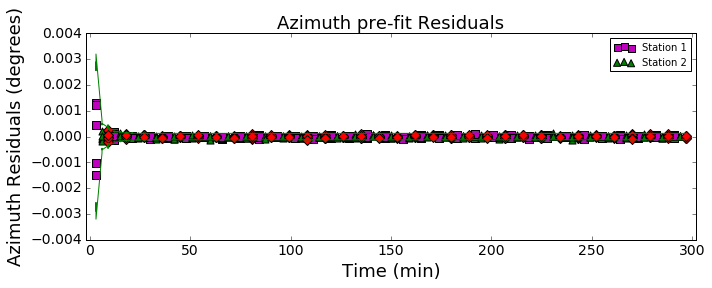

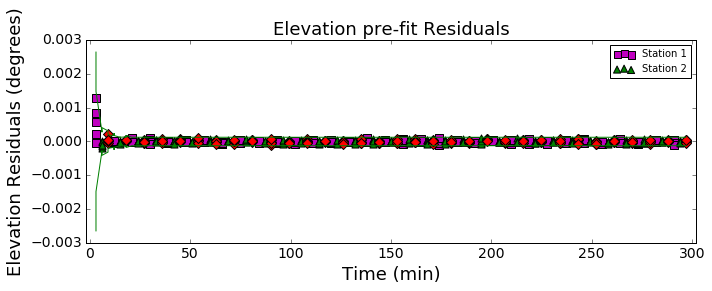

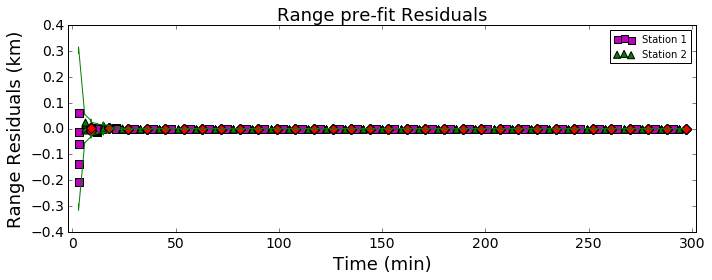

Post-fit RMS:
Azimuth = 0.0000 degrees
Elevation = 0.0000 degrees
Range = 0.00002 km


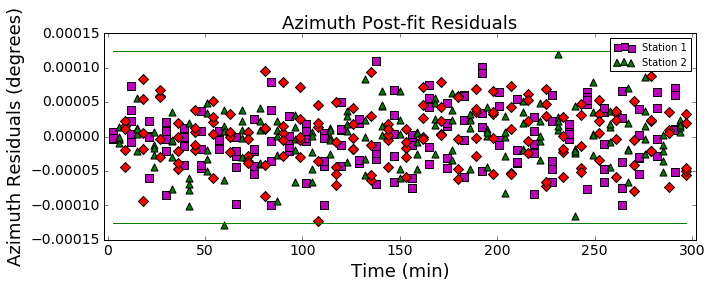

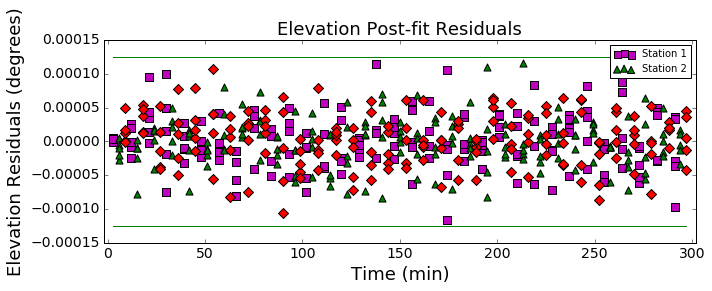

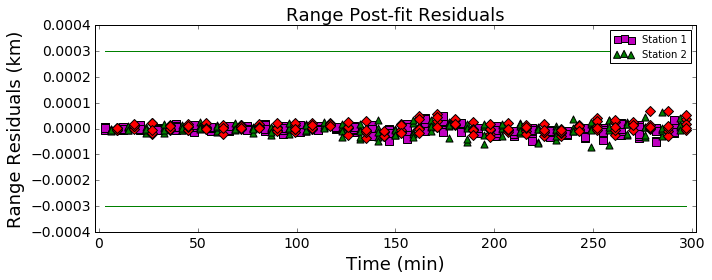

Density RMS = 0.33252 $(g/km^3)$


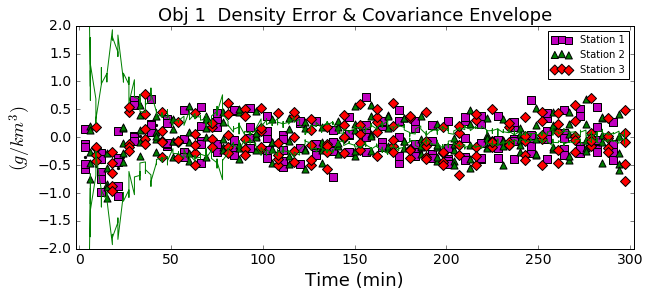

~~Obj 1 Results~~
Position RMS:
X = 0.0004 km
Y = 0.0005 km
Z = 0.0008 km
Overall = 0.0010 km

Velocity RMS:
X = 0.000008 km/second
Y = 0.000011 km/second
Z = 0.000010 km/second
Overall = 0.000017 km/s


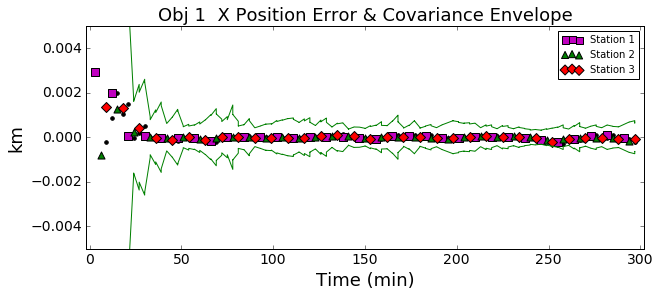

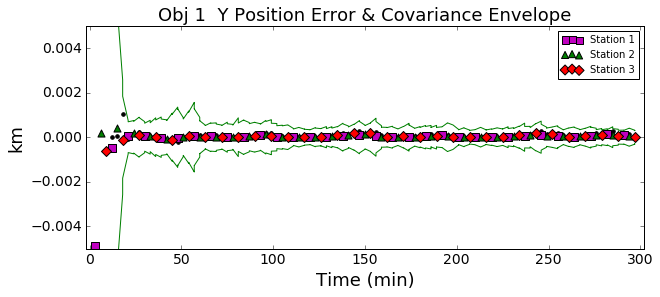

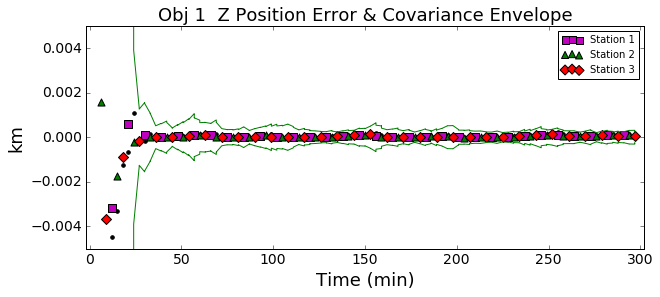

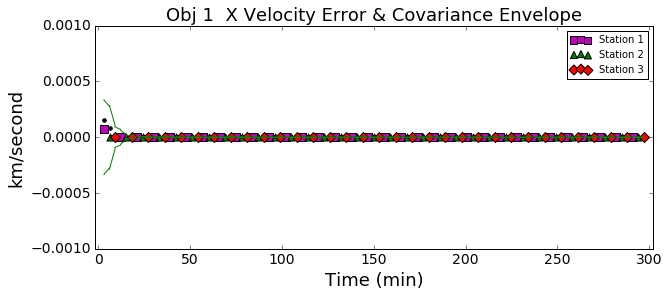

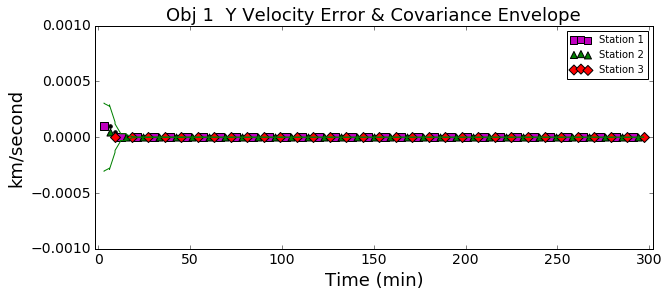

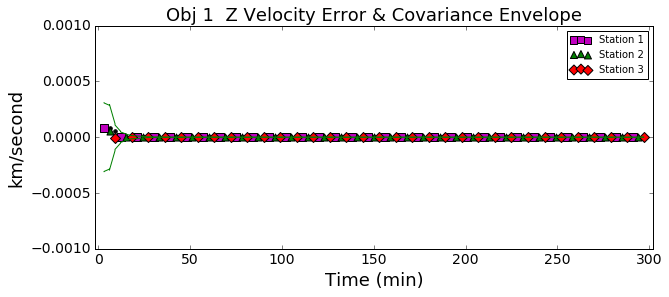

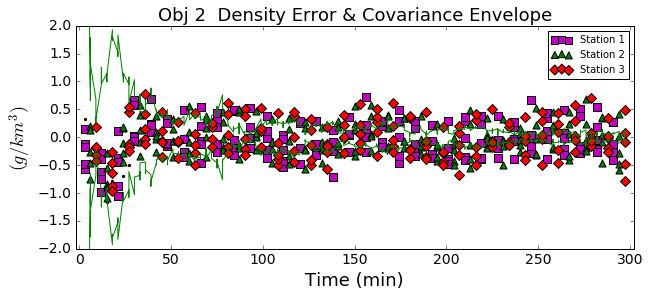

~~Obj 2 Results~~
Position RMS:
X = 0.0009 km
Y = 0.0010 km
Z = 0.0006 km
Overall = 0.0015 km

Velocity RMS:
X = 0.000008 km/second
Y = 0.000010 km/second
Z = 0.000008 km/second
Overall = 0.000015 km/s


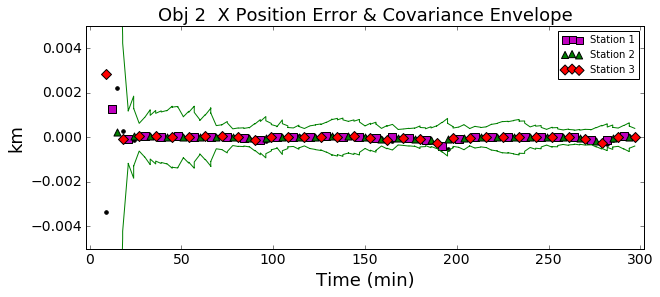

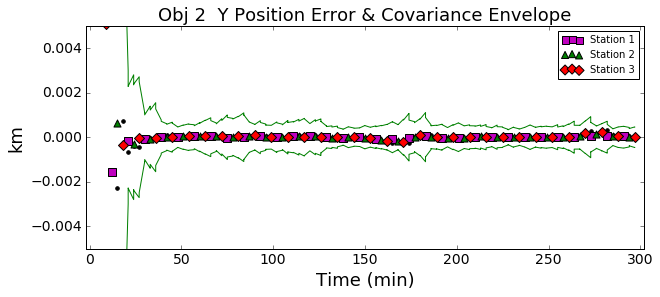

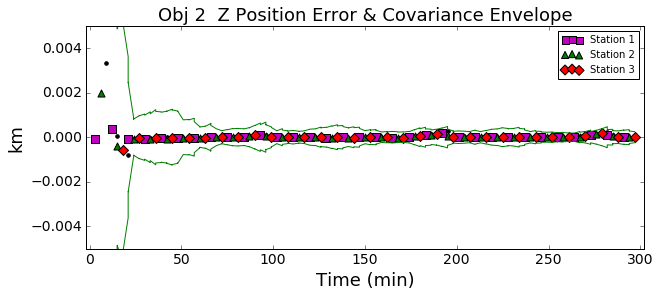

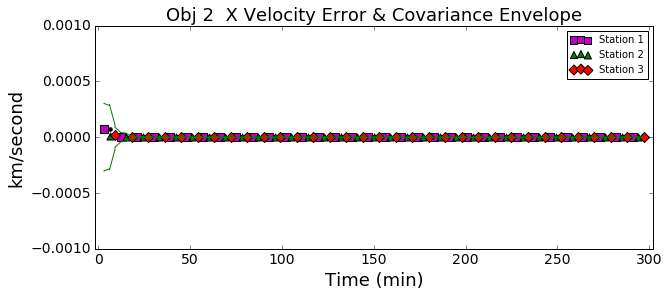

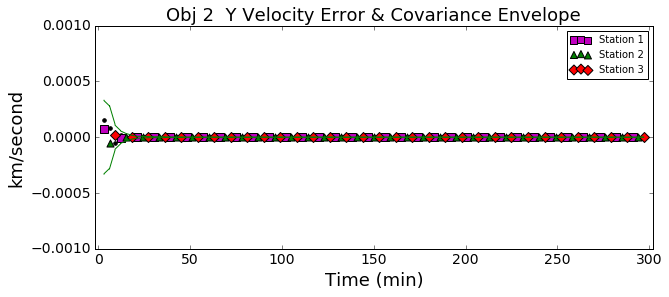

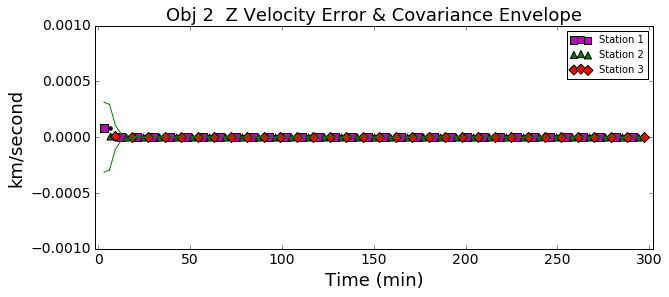

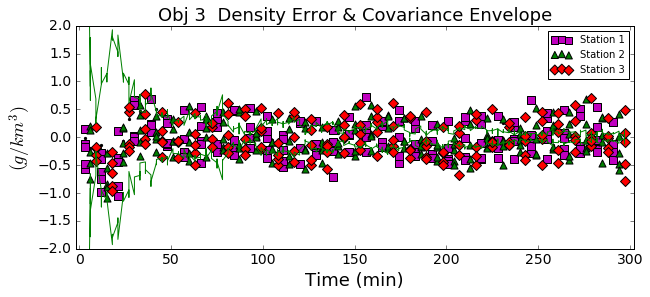

~~Obj 3 Results~~
Position RMS:
X = 0.0010 km
Y = 0.0004 km
Z = 0.0006 km
Overall = 0.0012 km

Velocity RMS:
X = 0.000010 km/second
Y = 0.000008 km/second
Z = 0.000009 km/second
Overall = 0.000016 km/s


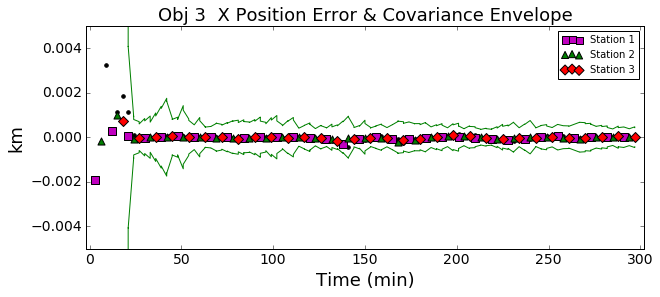

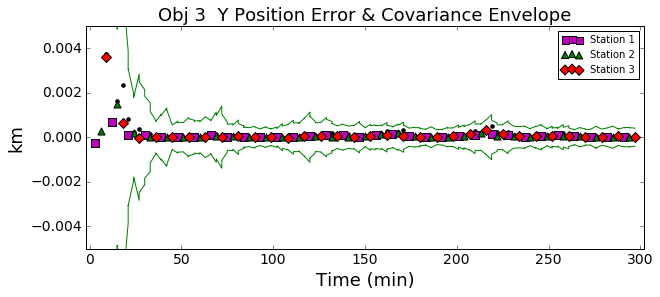

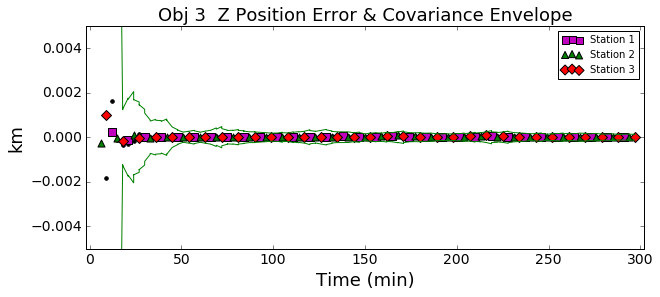

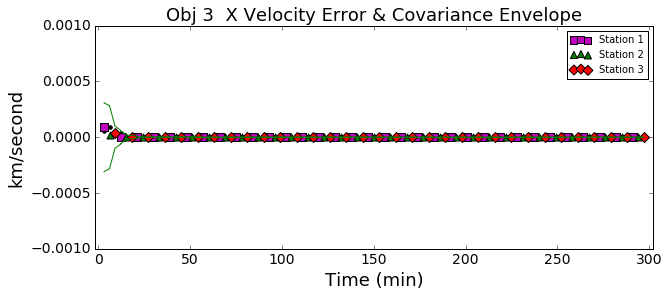

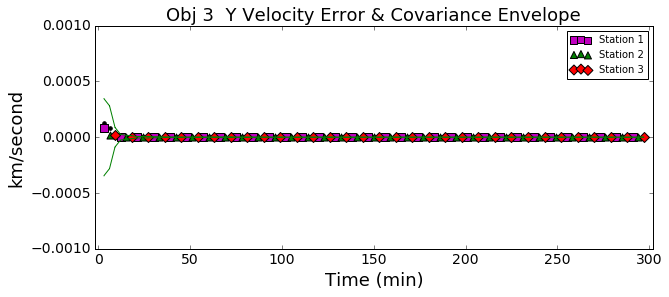

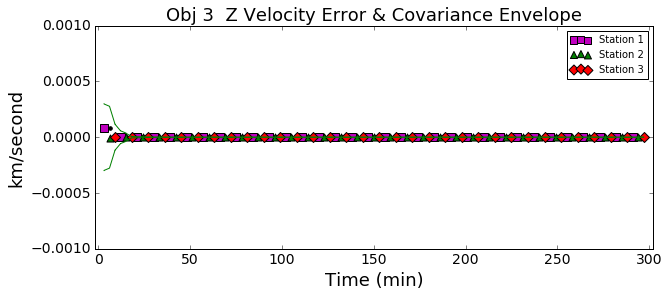

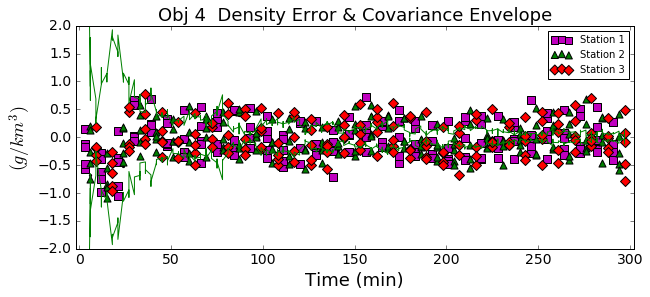

~~Obj 4 Results~~
Position RMS:
X = 0.0009 km
Y = 0.0009 km
Z = 0.0006 km
Overall = 0.0014 km

Velocity RMS:
X = 0.000009 km/second
Y = 0.000007 km/second
Z = 0.000009 km/second
Overall = 0.000015 km/s


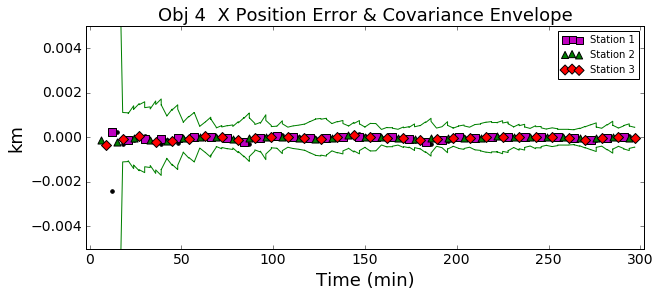

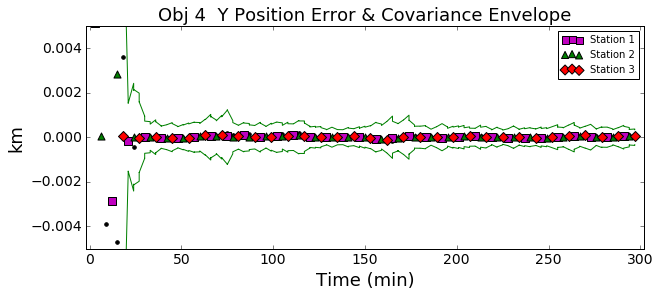

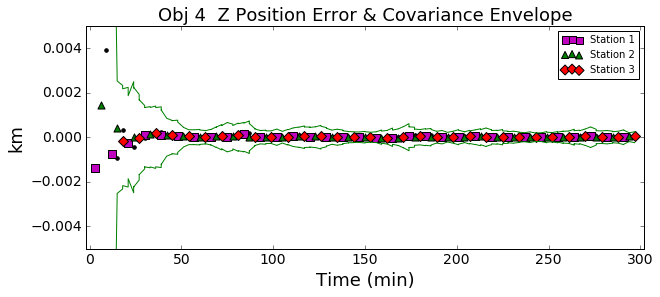

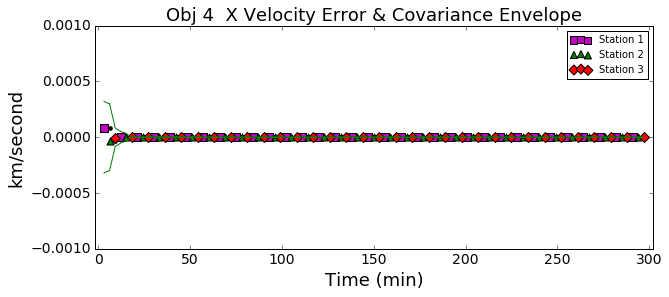

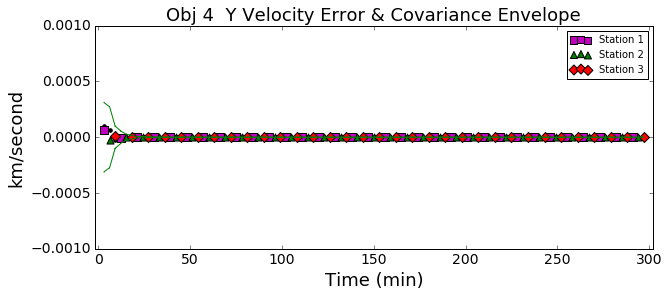

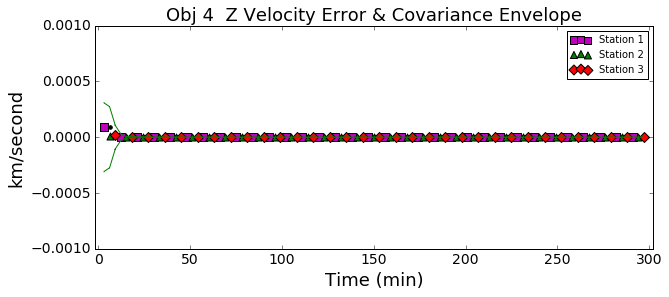

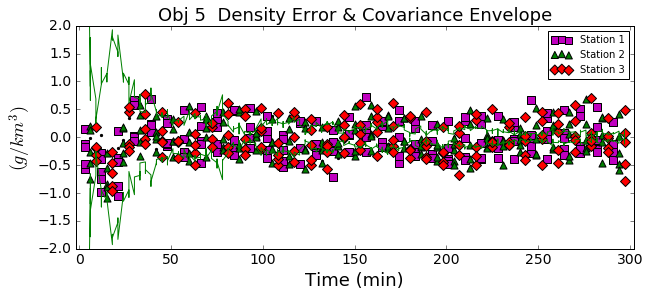

~~Obj 5 Results~~
Position RMS:
X = 0.0013 km
Y = 0.0010 km
Z = 0.0017 km
Overall = 0.0023 km

Velocity RMS:
X = 0.000009 km/second
Y = 0.000009 km/second
Z = 0.000014 km/second
Overall = 0.000018 km/s


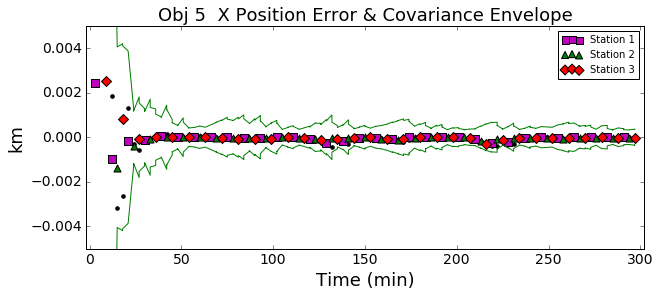

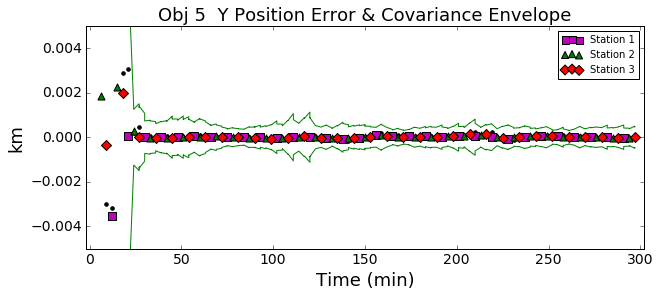

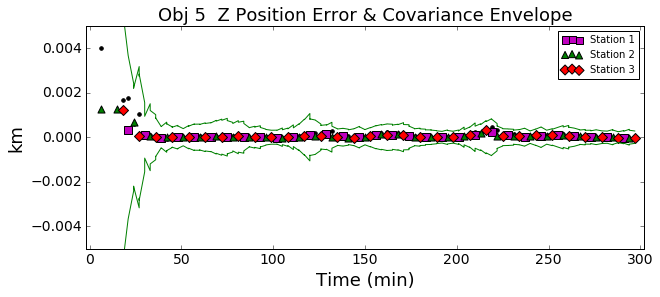

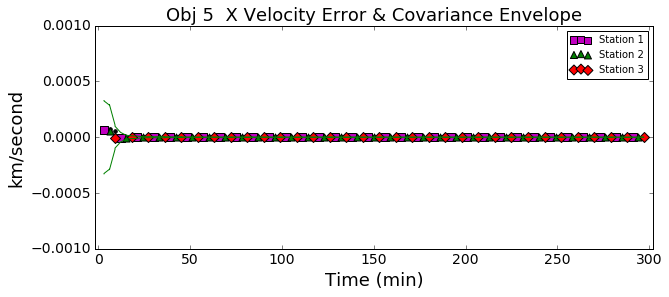

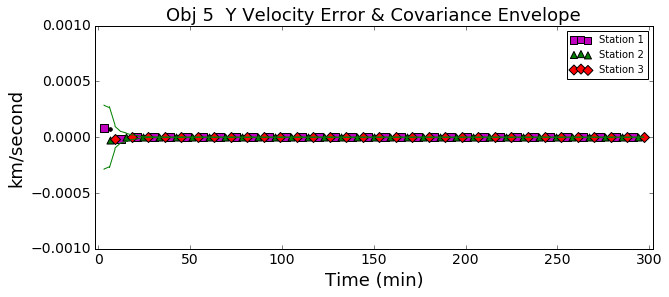

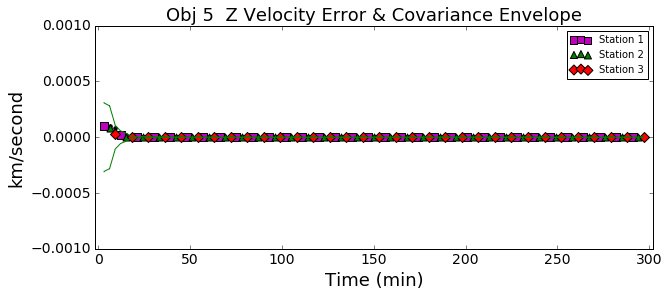

In [153]:

#Generate Plots for Analysis

x_range = .005
y_range = .005
z_range = .005

xv_range = 1e-3
yv_range = 1e-3
zv_range = 1e-3

density_range = 2

times = measurement_array[:, 0]

title_str = ''


filter_functions.calc_display_results_pre(pre_fit_list, prefit_bounds_list, measurement_array, R,\
                                          meas_type, stop_index, saveFig_bool, time_str)


filter_functions.calc_display_results(post_fit_list_EnKF, measurement_array, R, meas_type, stop_index, saveFig_bool,\
                                     time_str)


plot_error_covar_xref(P_list_EnKF, X_mean_updated_list_EnKF, X_mean_TU_list_EnKF, truth_xyz, true_density_array, \
                      density_range, x_range, y_range, z_range, xv_range, yv_range, zv_range,\
                      measurement_array, times, stop_index, saveFig_bool, time_str, title_str, num_of_objects)



In [152]:
indices = np.where(measurement_array[:, 1] == 1)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 2)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 3)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 4)[0]
print(indices)

[   0    1    2    3    4   15   16   17   18   19   30   31   32   33   34
   45   46   47   48   49   60   61   62   63   64   75   76   77   78   79
   90   91   92   93   94  105  106  107  108  109  120  121  122  123  124
  135  136  137  138  139  150  151  152  153  154  165  166  167  168  169
  180  181  182  183  184  195  196  197  198  199  210  211  212  213  214
  225  226  227  228  229  240  241  242  243  244  255  256  257  258  259
  270  271  272  273  274  285  286  287  288  289  300  301  302  303  304
  315  316  317  318  319  330  331  332  333  334  345  346  347  348  349
  360  361  362  363  364  375  376  377  378  379  390  391  392  393  394
  405  406  407  408  409  420  421  422  423  424  435  436  437  438  439
  450  451  452  453  454  465  466  467  468  469  480  481  482  483  484
  495  496  497  498  499  510  511  512  513  514  525  526  527  528  529
  540  541  542  543  544  555  556  557  558  559  570  571  572  573  574
  585  586  